#Smoke Detection via Image Segmentation - Analysis

---



This notebook represent's the initial work done for the SRM-UAH collaborative project on Smoke detection via Image Segmentation, involving analysis of data, basic preprocessing and model development. This showcases the complexity of the task at hand and preliminary insights attained through exploration of the data.<br><br>
The given problem statement is to create a model to effectively segment smoke from a GOES geostationary satellite image.<br><br>
The dataset provided to us contains two parts, one being multiband raster images in the form of ```.tif``` files and binary segmentation mask images in the form of ```.bmp``` files.<br><br>Even though these details are known, it is not enough to arrive at a solution of "How to find the best possible solution to perform Image segmentation to extract plumes of smoke from a satellite image?".
In order to answer that question, I would like to quote Charles Kettering,


> “A Problem Well Stated is Half Solved”

<br>So if we manage to state our problems well, we can move closer to the solution, and we can arrive at a definition by the following methods:<br>

1.   **Analysing the problem**
2.   **Testing it with simple solutions**
<br>

Through this, we can not only understand what the problem is, we can also understand how complex it is.

<br>

Now without further ado, venture through our journey of exploration!! 🚀

## **Installation and Import of Modules and Dataset** 📥

We will first install some libraries that will come in handy later on.<br><br>The first one being Rasterio, which is a commonly used library for raster processing and handling raster images, and hence has abundance of application in Image processing.<br><br>Another library being Pillow, another common image editing library used for manipulating multiple types of image formats.

In [ ]:
!pip install rasterio
!pip install -U tensorflow
!pip install -U keras
!pip install osgeo
!pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached GDAL-3.7.0.tar.gz (775 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for GDAL
  Running setup.py clean for GDAL
Failed to build GDAL
ERROR: Could not build wheels for GDAL, which is required to install pyproject.toml-based projects
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/si

We have used `google.colab.drive` so that the dataset used can be accessed through permission only, so as to maintain data integrity.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


The following contains the list of libraries and library functions we will need for further use.

In [ ]:
from osgeo import gdal
import tensorflow as tf
import cv2
import matplotlib
import os,re
import rasterio
from random import randint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rasterio.plot import show, show_hist
from sklearn.model_selection import train_test_split
import sys,traceback,signal
import keras
import segmentation_models as sm

Segmentation Models: using `keras` framework.


Now, the given dataset had .tif images within the 'images' file and .bmp files within the 'mask' file. Below we have extracted all the paths to each of the images and added them into two seperate lists, `tiffol` for the .tif images and `bmpfol` for the .bmp images.<br><br>We find that there are a total of 352 image to mask pairs within the dataset provided.

In [ ]:
tifpath = "/content/drive/MyDrive/dataset/images/"
bmppath = "/content/drive/MyDrive/dataset/mask/"
bmpfol = []
tiffol=[]
for image in os.listdir(tifpath):
    tiffol.append(image)
for _ in os.listdir(bmppath):
    bmpfol.append(_)

tiffol = sorted(tiffol)
bmpfol=sorted(bmpfol)
print('Instances of Mask Dataset:',len(bmpfol))
print('\nInstances of Raster Image Dataset:',len(tiffol))

Instances of Mask Dataset: 352

Instances of Raster Image Dataset: 352


The following shows sample directories to get a better understanding of the filenames.<br><br>As shown below, we can see that the names of the image files show the time and coordinate values of the image taken, and given the time value is very large, it must have been calculated with small units of time, possibly down to microseconds and the location values show four coordinates, the first two to signify the coordinates of the top left corner of the image and the next two to signify the coordinates of the bottom right corner of the image.

In [ ]:
bmpd = bmppath + bmpfol[28]
tifd = tifpath + tiffol[28]
print("Sample .bmp file directory:\n",bmpd,"\n")
print("Sample .tif file directory:\n",tifd,"\n")

Sample .bmp file directory:
 /content/drive/MyDrive/dataset/mask/time-20171161915394-loc--111.6_34.3_-110.8_34.9.bmp 

Sample .tif file directory:
 /content/drive/MyDrive/dataset/images/time-20171161915394-loc--111.6_34.3_-110.8_34.9.tif 



## **Preliminary Wrangling and EDA** 🔍

Now, lets explore the data and see if we can analyse some key problems with our data.

### Understanding and Visualizing a sample 🖼️

In [ ]:
plt.style.use('dark_background')

Below, we have used `rasterio.open` to open the Bitmap image from the sample .bmp directory from before. This will create a `DatasetReader` for unbuffered data and metadata reading. We do this to see if we can find any metadata that may be of use to us, and help better explain the images.

In [ ]:
srb = rasterio.open(bmpd)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


As we can see above, opening the image returns a `NotGeoreferencedWarning` which entails that the image is not georeferenced.<br> We can however utilize the data's `profile` property to get a bunch of metadata information about the image as shown below.

The profile gives us information like the format drivers used, datatype, resolution of image, raster count, coordinate reference system and the Affine transformation done on the image. These can be seen for our .bmp image below.

In [ ]:
srb.profile

{'driver': 'BMP', 'dtype': 'uint8', 'nodata': None, 'width': 60, 'height': 55, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'blockysize': 1, 'tiled': False}

We have also tried to check it's corresponding `colormap` and `ColorInterp` objects. The result is as follows.

In [ ]:
print("Rasterio Colormap object created for .bmp file:\n",srb.colormap,"\n\nRasterio ColorInterp object created for .bmp file:\n",srb.colorinterp)

Rasterio Colormap object created for .bmp file:
 <built-in method colormap of DatasetReader object at 0x7f370220a140> 

Rasterio ColorInterp object created for .bmp file:
 (<ColorInterp.palette: 2>,)


Now trying the same thing with the .tif file, we get the following.

In [ ]:
srt = rasterio.open(tifd)

Upon running, we weren't hit with a `NotGeoreferencingWarning` warning, which would mean that the .tif file is georeferenced. We can confirm that by using `DatasetReader.profile` .

In [ ]:
srt.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 60, 'height': 55, 'count': 6, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.013333333333333286, 0.0, -111.6,
       0.0, -0.010909090909090934, 34.9), 'blockysize': 22, 'tiled': False, 'interleave': 'pixel'}

As shown above, under the `crs` property, the coordinate reference system used for the .tif image is ESPG 4326. Therefore it is georeferenced. There are also some additional properties to the .tif image profile as well.

In [ ]:
print("Rasterio Colormap object created for .tif file:\n",srt.colormap,"\n\nRasterio ColorInterp object created for .tif file:\n",srt.colorinterp)

Rasterio Colormap object created for .tif file:
 <built-in method colormap of DatasetReader object at 0x7f370220a040> 

Rasterio ColorInterp object created for .tif file:
 (<ColorInterp.gray: 1>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>)


The `ColorInterp` object now shows the colour interpretation of six rasters that reside within the .tif image. The first is in grayscale while the others are undefined. Also since it has 6 bands, we cannot set the color interpretation to RGB, Black and White or even RGBA. This means the wavelength/spectrum is much larger.

We can also try using the `descriptions` attribute of the `DatasetReader` to see if we can get more insights that have already been provided.

In [ ]:
srb.descriptions

(None,)

In [ ]:
srt.descriptions

(None, None, None, None, None, None)

Both types have no descriptions whatsoever and hence doesnt provide us any information.

Since there isnt much information provided via the metadata, we can try visualizing a sample image to see what we are dealing with.<br>
Since the .tif images' color interpretation shows only the first raster to have "Gray" as its color interpretation and there is no attribute ```photometric```
nor description for the **Photometric interpretations** of the images, we will consider visualizing all the bands with the same color scheme as the first band, which is gray or gray-scale.<br><br>
The following is its respective Segmentation mask.

Width:60, Height:55



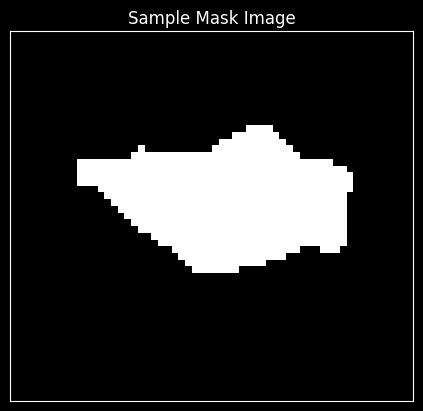

In [ ]:
plt.imshow(srb.read(1), cmap='gray')
print(f"Width:{srb.width}, Height:{srb.height}\n")
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.title("Sample Mask Image")
plt.show()

The following are the image's raster bands with the gray-scale color scheme

In [ ]:
Gray=plt.get_cmap("gray",256)
figtif, axtif = plt.subplots(2,3, figsize=(20,10),layout="constrained")
for i in range(2):
  for j in range(3):
    axtif[i][j].axes.xaxis.set_visible(False)
    axtif[i][j].axes.yaxis.set_visible(False)
plt.suptitle("Sample Geostationary Image (Gray-Scale)",fontsize=16)
for _ in range(1,7):
    show((srt, _), ax=axtif[((_-1)//3)][(_-1)%3], cmap=Gray, title=f'Band {_}')
plt.show()

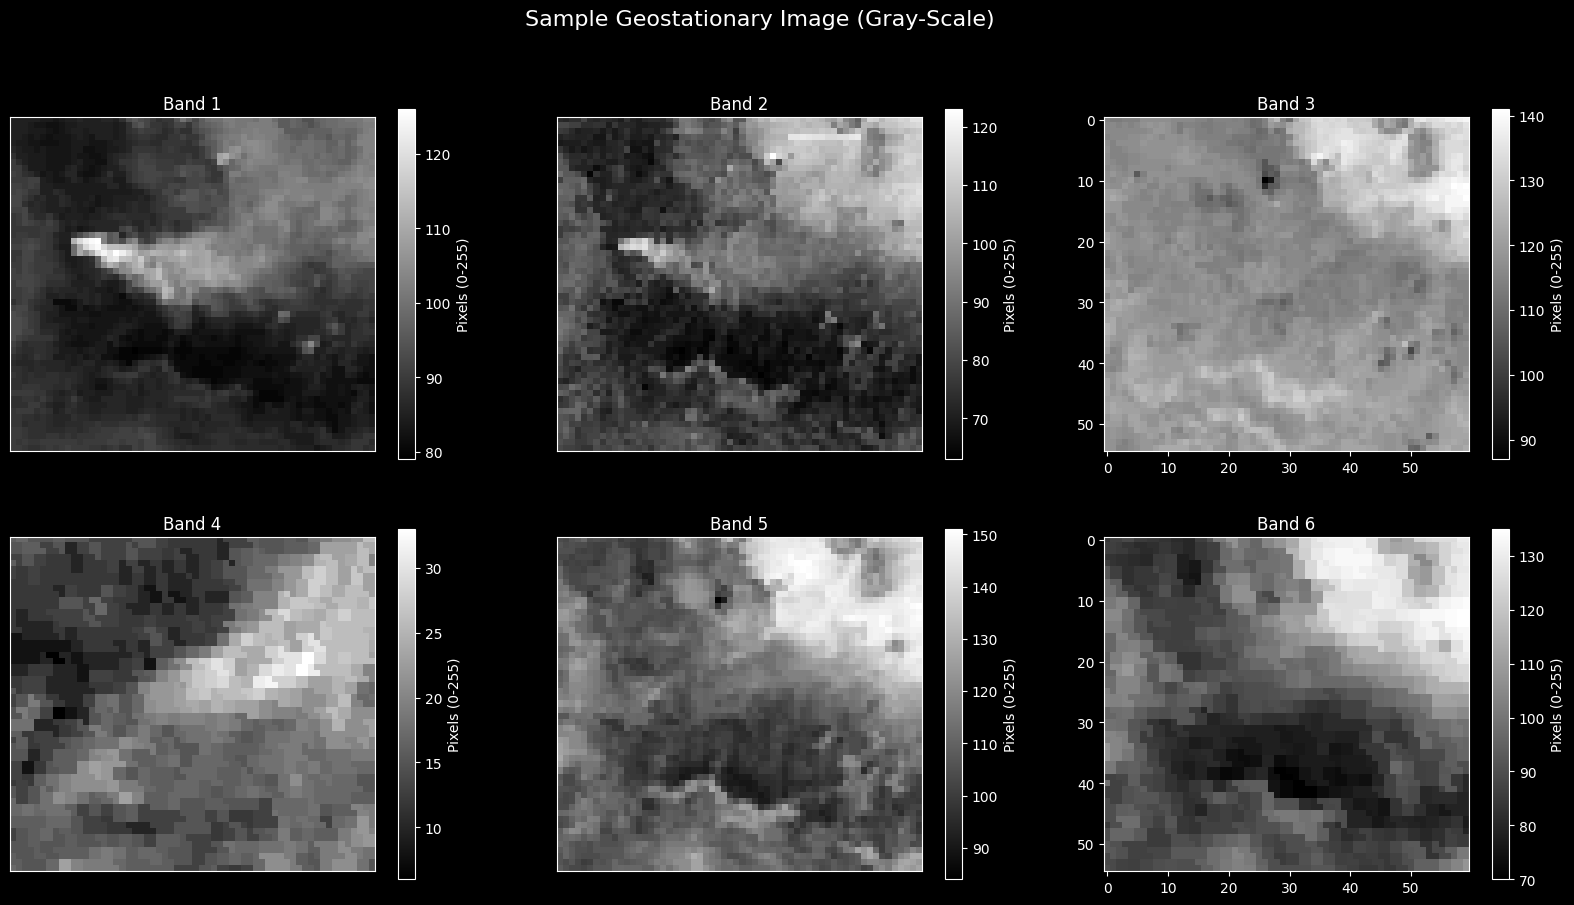

In [ ]:
figtif, axtif = plt.subplots(2,3, figsize=(20,10))
for i in range(2):
  for j in range(2):
    axtif[i][j].axes.xaxis.set_visible(False)
    axtif[i][j].axes.yaxis.set_visible(False)
plt.suptitle("Sample Geostationary Image (Gray-Scale)",fontsize=16)
for i in range(1,7):
  plt.subplot(2,3,i)
  plt.imshow(srt.read(i),cmap=Gray)
  plt.title(f'Band {i}')
  plt.colorbar(label="Pixels (0-255)")
plt.show()

Now we reverse the gray scale and visualize again

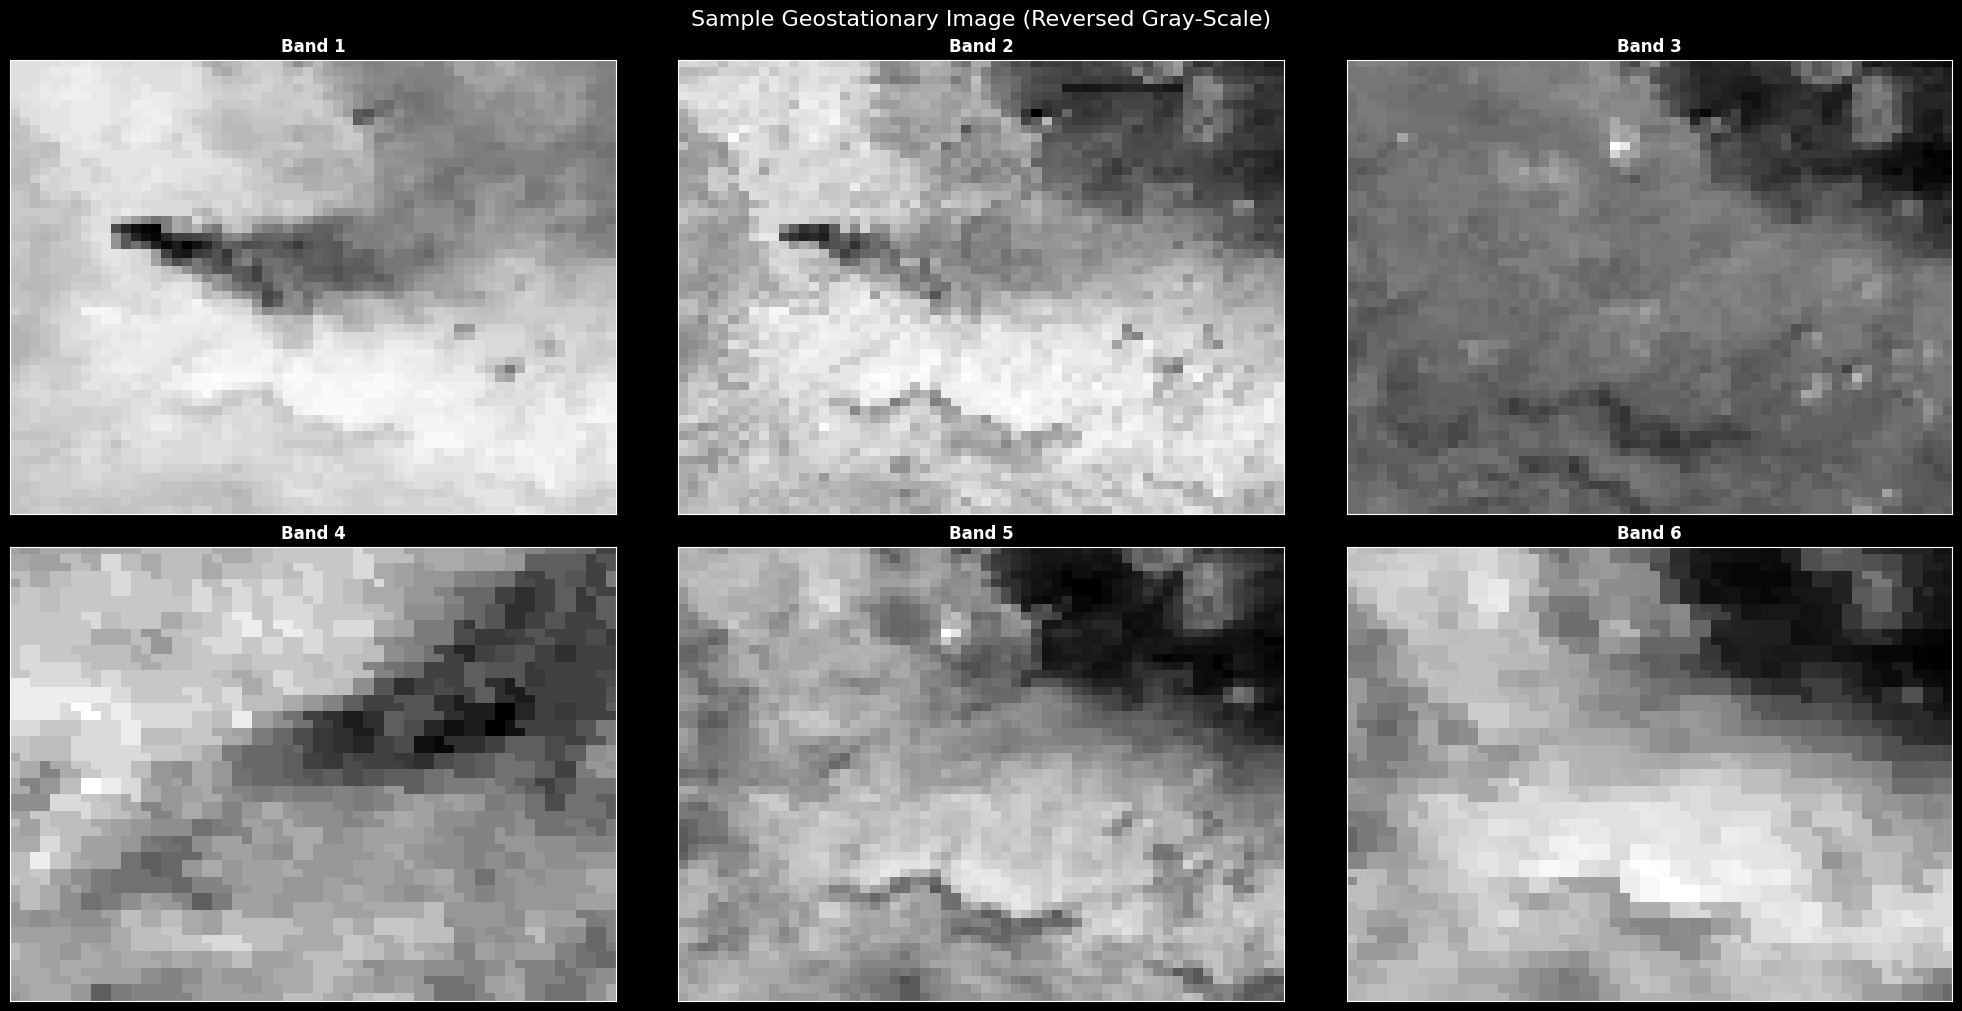

In [ ]:
Grayr=plt.get_cmap("gray_r",256)
figtif, axtif = plt.subplots(2,3, figsize=(20,10),layout="constrained")
for i in range(2):
  for j in range(3):
    axtif[i][j].axes.xaxis.set_visible(False)
    axtif[i][j].axes.yaxis.set_visible(False)
plt.suptitle("Sample Geostationary Image (Reversed Gray-Scale)",fontsize=16)
for _ in range(1,7):
    show((srt, _), ax=axtif[((_-1)//3)][(_-1)%3], cmap=Grayr, title=f'Band {_}')
plt.show()

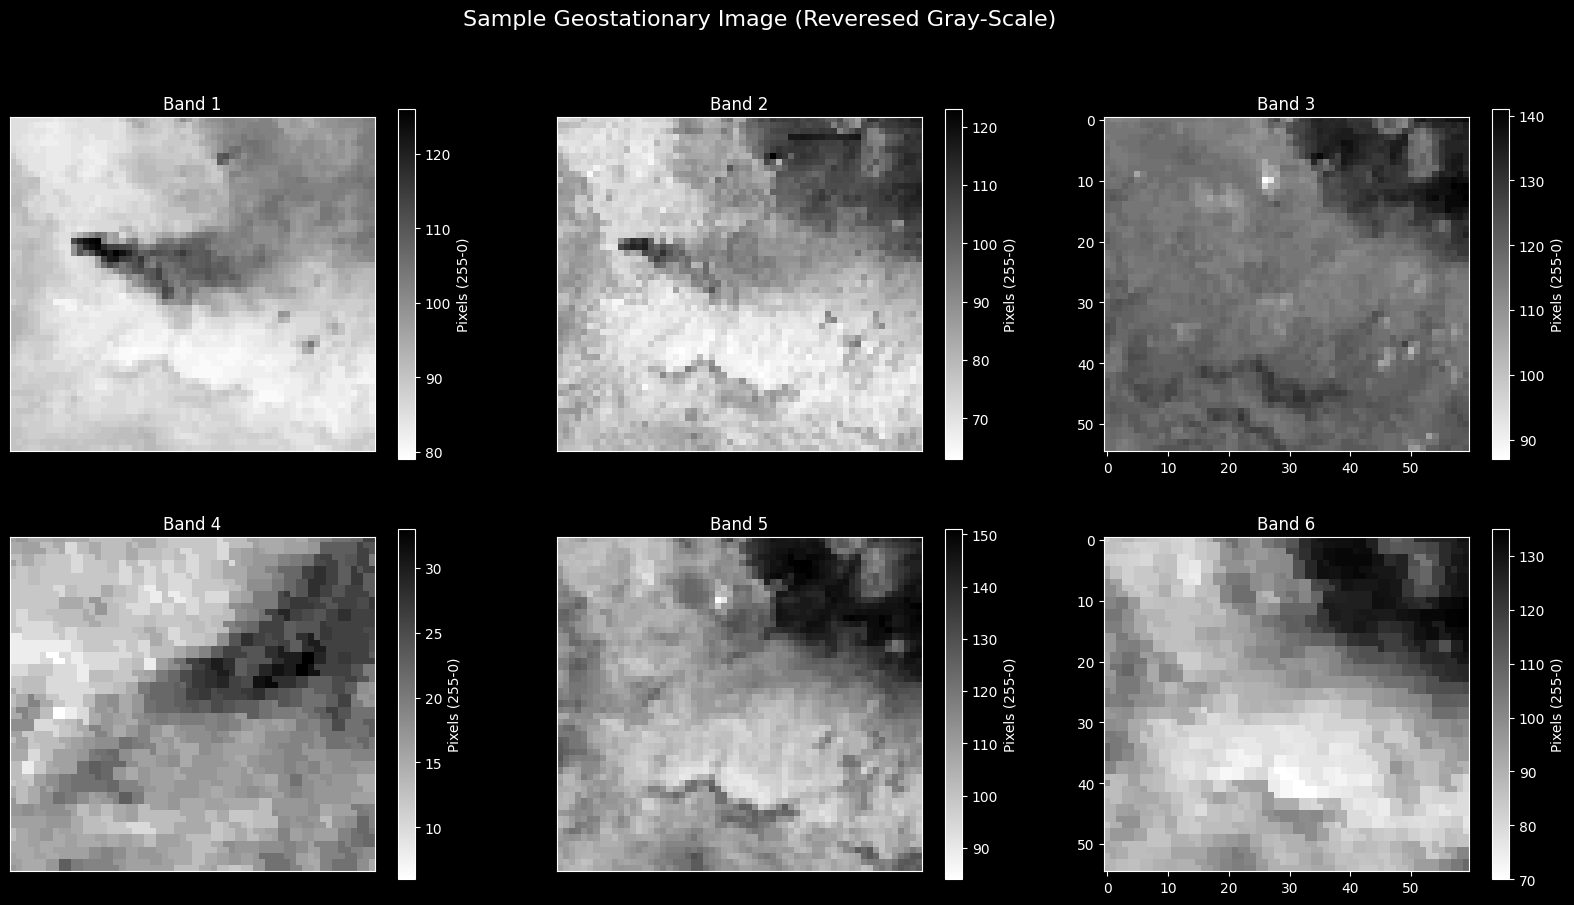

In [ ]:
figtif, axtif = plt.subplots(2,3, figsize=(20,10))
for i in range(2):
  for j in range(2):
    axtif[i][j].axes.xaxis.set_visible(False)
    axtif[i][j].axes.yaxis.set_visible(False)
plt.suptitle("Sample Geostationary Image (Reveresed Gray-Scale)",fontsize=16)
for i in range(1,7):
  plt.subplot(2,3,i)
  plt.imshow(srt.read(i),cmap=Grayr)
  plt.title(f'Band {i}')
  plt.colorbar(label="Pixels (255-0)")
plt.show()

Now, through displaying the images, we can see so much diversity between the rasters and thier representation of the smoke. Raster 1 and 2 are the ones that clearly demonstrate the presence of smoke as compared to the others.

We will now analyse the sample image a little further, but first let us convert the images into arrays.

In [ ]:
#Tagged Raster Image into N-Dimensional Array
tifa = srt.read()
meta = srt.meta
print("Matrix Representation of .tif image:\n")
print(tifa,"\n\nDatatype:",tifa.dtype)
print("\nMatrix Shape:",tifa.shape)

Matrix Representation of .tif image:

[[[ 85  85  85 ... 101 103 103]
  [ 85  85  85 ... 101 102 102]
  [ 85  85  85 ... 100 102 103]
  ...
  [ 90  90  89 ...  87  89  89]
  [ 90  89  90 ...  89  89  87]
  [ 90  90  89 ...  89  87  88]]

 [[ 73  72  74 ... 112 116 116]
  [ 80  80  78 ... 112 113 114]
  [ 77  76  73 ... 107 109 110]
  ...
  [ 81  85  81 ...  80  86  80]
  [ 82  80  80 ...  83  83  78]
  [ 80  78  78 ...  83  80  83]]

 [[115 113 113 ... 137 138 139]
  [116 116 115 ... 134 132 135]
  [116 116 116 ... 131 132 134]
  ...
  [118 119 118 ... 122 122 122]
  [118 118 116 ... 123 122 121]
  [118 118 115 ... 121 121 123]]

 [[ 16  17  17 ...  22  26  26]
  [ 15  15  16 ...  26  24  24]
  [ 15  15  16 ...  26  26  24]
  ...
  [ 16  15  15 ...  19  18  18]
  [ 16  16  15 ...  18  18  15]
  [ 17  16  15 ...  18  18  15]]

 [[104 103 106 ... 140 144 146]
  [106 104 105 ... 138 140 140]
  [105 105 105 ... 135 138 142]
  ...
  [106 111 108 ... 123 129 129]
  [106 104 107 ... 128 127 1

In [ ]:
bmpa = np.array(srb.read())
print("Matrix Shape:",bmpa.shape)
print("Matrix Representation of .bmp file\n")
bmpa = np.array(srb.read(1))
#Bitmap Image into N-Dimensional array
print(bmpa,"\n\nDatatype:",bmpa.dtype)
print("\nMatrix Shape:",bmpa.shape)

Matrix Shape: (1, 55, 60)
Matrix Representation of .bmp file

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 

Datatype: uint8

Matrix Shape: (55, 60)


Now let us try overlapping the bitmap over the raster and extract only the smoke plume out of the .tif image, in order to make sense out of the information the satellite image is providing us.

In [ ]:
def rasterextract(arr,bit):
  return np.multiply(arr,bit).astype(np.dtype("uint8"))

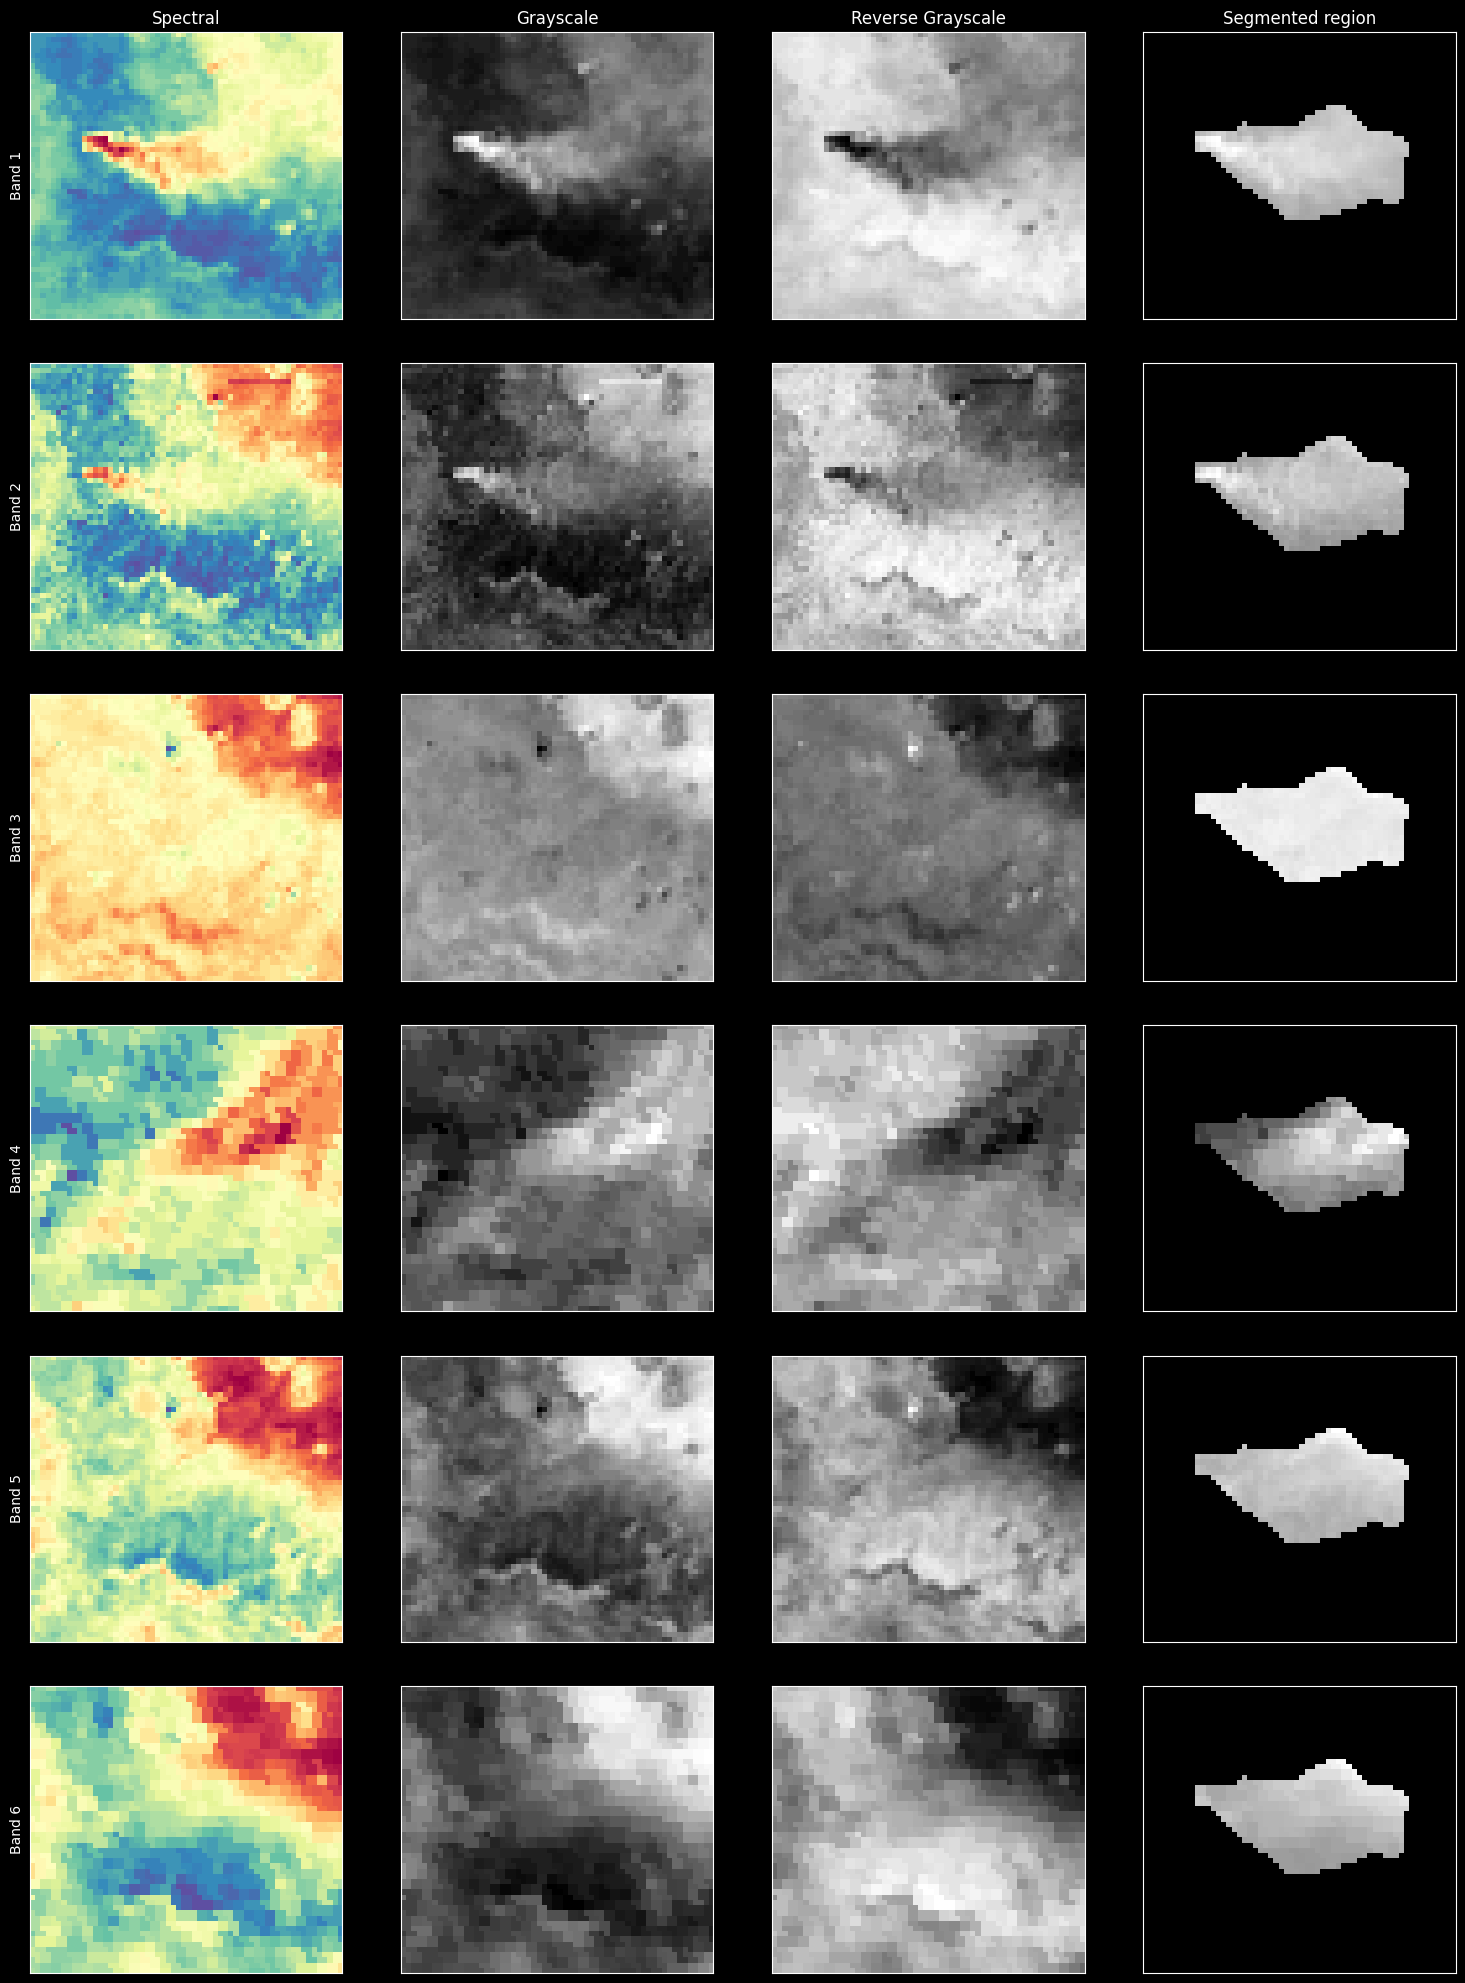

In [ ]:
extif, exax = plt.subplots(6,4, figsize=(15,20),layout="tight")
plt.tight_layout()
exax[0][0].title.set_text('Spectral') # Based on the Black-Purple-Blue-Green-Yellow-Red-White color spectrum
exax[0][1].title.set_text('Grayscale')
exax[0][2].title.set_text('Reverse Grayscale')
exax[0][3].title.set_text('Segmented region')
for i in range(len(tifa)):
  exax[i][0].axes.xaxis.set_visible(False)
  exax[i][0].set_ylabel("Band " + str(i+1))
  plt.setp(exax[i][0].get_yticklabels(), visible=False)
  exax[i][0].tick_params(axis=u'both', which=u'both',length=0)
  exax[i][1].axes.xaxis.set_visible(False)
  exax[i][1].axes.yaxis.set_visible(False)
  exax[i][2].axes.xaxis.set_visible(False)
  exax[i][2].axes.yaxis.set_visible(False)
  exax[i][3].axes.xaxis.set_visible(False)
  exax[i][3].axes.yaxis.set_visible(False)
  exax[i][0].imshow(tifa[i], cmap= "Spectral_r")
  exax[i][1].imshow(tifa[i], cmap=Gray)
  exax[i][2].imshow(tifa[i], cmap=Grayr)
  exax[i][3].imshow(rasterextract(tifa[i]/255,bmpa), cmap=Gray)

The first column shows the images using a Spectral color scheme based on the  Black-Purple-Blue-Green-Yellow-Red-White color spectrum, the second shows the grayscaled version, the third shows the reversed gray-scale version and the last column shows the segmented region of smoke from each raster.<br>
As we can see, just directly overlapping the bitmap over the rasters individually shows that only the first two rasters show any significant value as they show the region of smoke while the others dont give as much distinction with respect to the plume itself.

### Dataframe representation of image dimensions 🪟

#### Complete Conversion of Dataset into arrays💫

So far we have merely taken one image from the dataset as a sample for brief exploratory analysis, we will now convert the entire dataset into array and perform wrangling for further analysis.

In [ ]:
Y = []
for path in bmpfol:
  with rasterio.open(os.path.join(bmppath,path)) as srb:
    imgy = srb.read()
  Y.append(imgy)

In [ ]:
X = []
for path in tiffol:
  with rasterio.open(os.path.join(tifpath,path)) as srt:
    imgx = srt.read()
  X.append(imgx)

In [ ]:
len(X),len(Y)

(352, 352)

Below shows a dataframe that contains all the assortment of dimension pairs of the images to get a better understanding of the dataset.

In [ ]:
rastcols = ['TiffHeight','TiffWidth','BmpHeight','BmpWidth']
rastframe = pd.DataFrame(columns = rastcols)
for i in range(0,len(X)):
    rastframe.loc[len(rastframe.index)]=[X[i].shape[1],X[i].shape[2],Y[i].shape[1],Y[i].shape[2]]
rastframe

TiffHeight  TiffWidth  BmpHeight  BmpWidth
0           397        352        397       352
1            55         47         55        47
2            46         52         46        52
3           231        167        231       167
4            83         82         83        82
..          ...        ...        ...       ...
347         110         66        110        66
348         161        124        161       124
349         386        231        386       231
350         120        169        120       169
351         117         87        117        87

[352 rows x 4 columns]

#### Range of dimensions

In [ ]:
print("Maximum Height =",rastframe['TiffHeight'].max(),"\nMaximum Width = ",rastframe['TiffWidth'].max())

Maximum Height = 1572 
Maximum Width =  7080


In [ ]:
print("Minimum Height =",rastframe['TiffHeight'].min(),"\nMinimum Width = ",rastframe['TiffWidth'].min())

Minimum Height = 18 
Minimum Width =  21


Let us pick the largest images and smallest images and visualize them seperately.

####Largest Height image

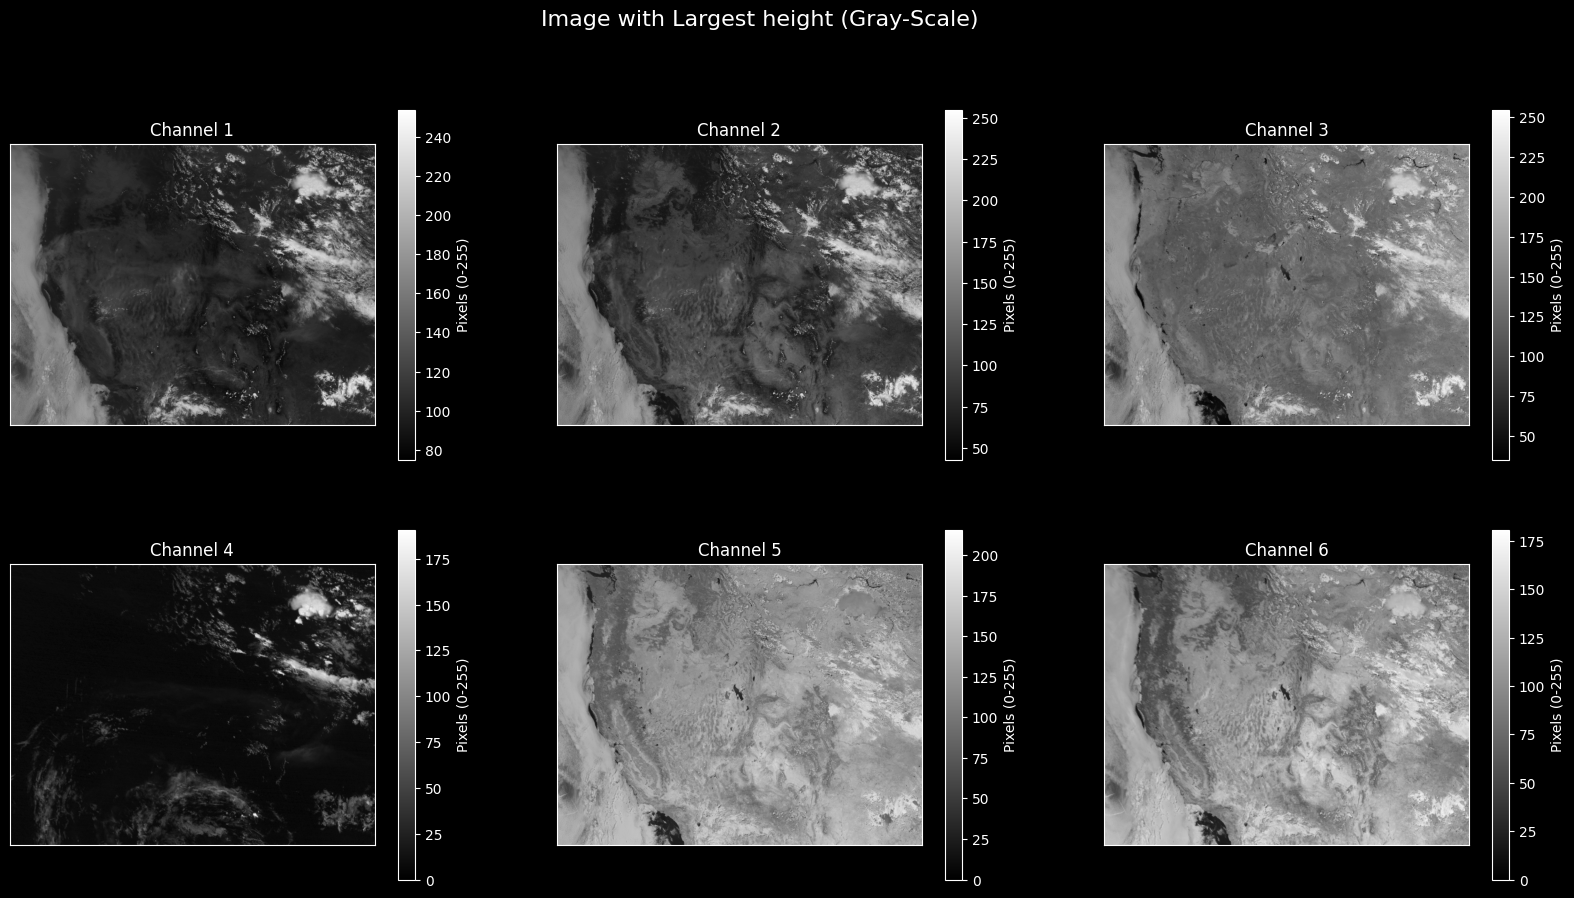

In [ ]:
srtlh = X[rastframe[rastframe['TiffHeight']==rastframe['TiffHeight'].max()].index[0]]
srblh = Y[rastframe[rastframe['TiffHeight']==rastframe['TiffHeight'].max()].index[0]].reshape(1572, 2039)
figtif, axtif = plt.subplots(2,3, figsize=(20,10))
for i in range(2):
  for j in range(3):
    axtif[i][j].axes.xaxis.set_visible(False)
    axtif[i][j].axes.yaxis.set_visible(False)
plt.suptitle("Image with Largest height (Gray-Scale)",fontsize=16)
for i in range(1,7):
  plt.subplot(2,3,i)
  plt.imshow(srtlh[i-1],cmap=Gray)
  plt.title(f'Channel {i}')
  plt.colorbar(label="Pixels (0-255)")
plt.show()

Shape: (1572, 2039)


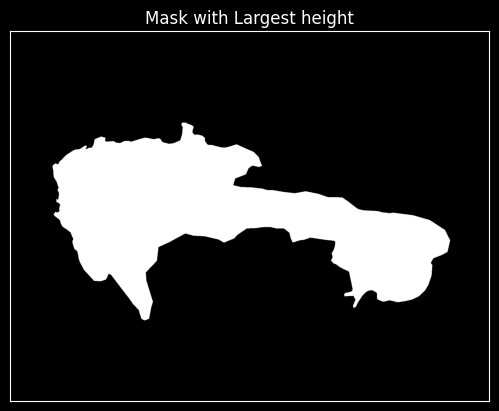

In [ ]:
print("Shape:",srblh.shape)
plt.imshow(srblh,cmap=Gray)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.title("Mask with Largest height")
plt.show()

As shown above, the image contains a very large plume of smoke that spans over a large area of geographical surface and is an invaluable image for gathering information for the learning of the model.

####Largest Width image

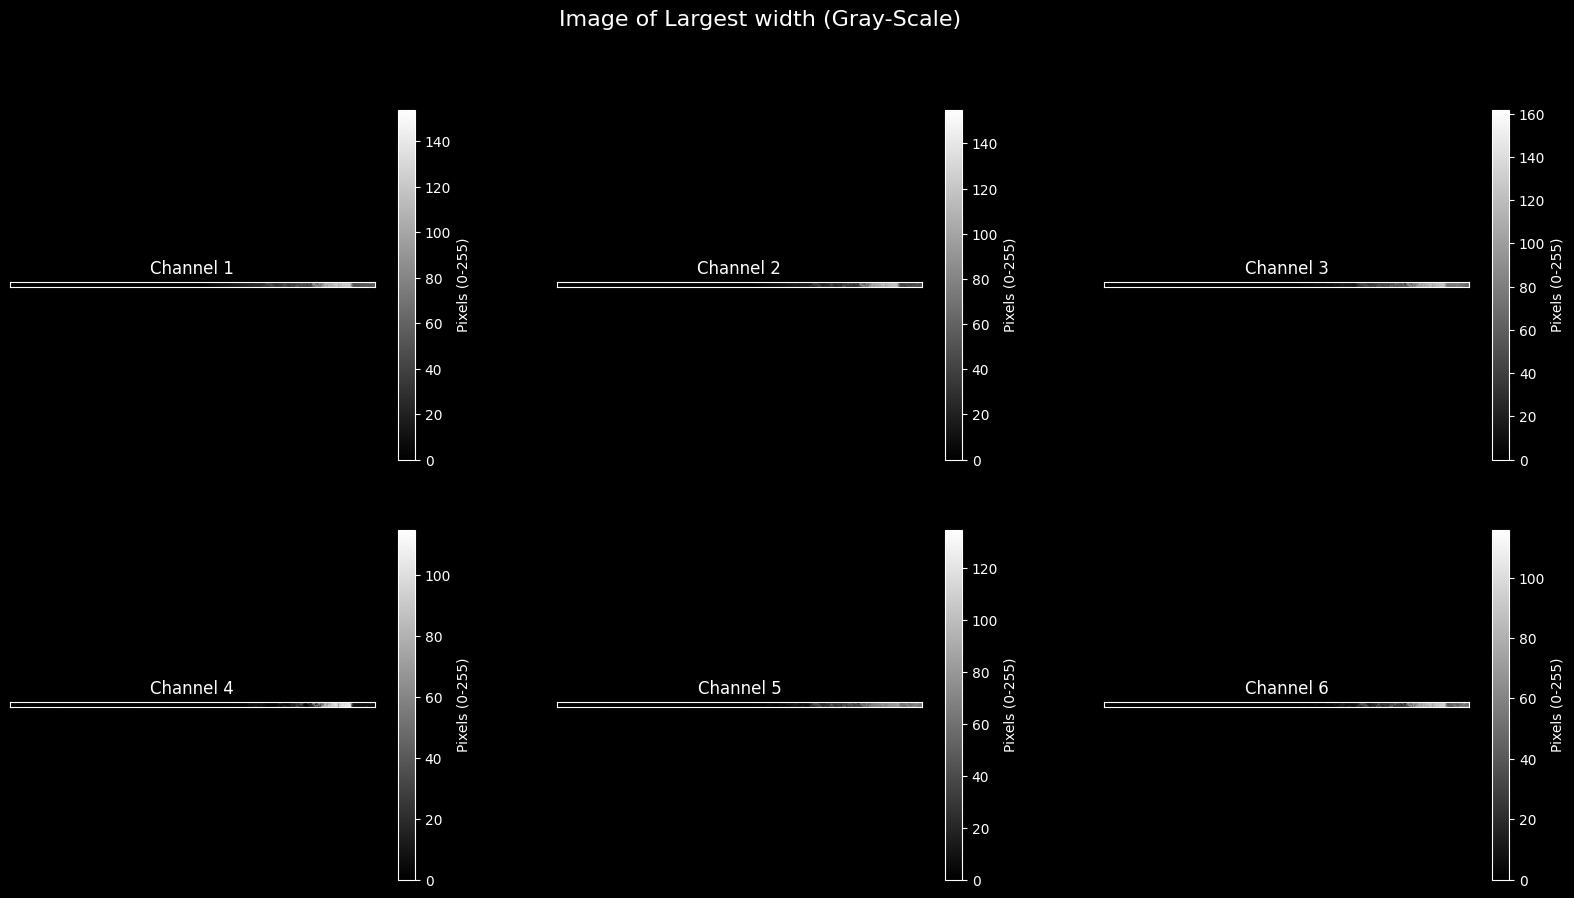

In [ ]:
srtlw = X[rastframe[rastframe['TiffWidth']==rastframe['TiffWidth'].max()].index[0]]
srblw = Y[rastframe[rastframe['TiffWidth']==rastframe['TiffWidth'].max()].index[0]][0]
figtif, axtif = plt.subplots(2,3, figsize=(20,10))
for i in range(2):
  for j in range(3):
    axtif[i][j].axes.xaxis.set_visible(False)
    axtif[i][j].axes.yaxis.set_visible(False)
plt.suptitle("Image of Largest width (Gray-Scale)",fontsize=16)
for i in range(1,7):
  plt.subplot(2,3,i)
  plt.imshow(srtlw[i-1],cmap=Gray)
  plt.title(f'Channel {i}')
  plt.colorbar(label="Pixels (0-255)")
plt.show()

Shape: (101, 7080)


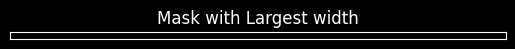

In [ ]:
print("Shape:",srblw.shape)
plt.imshow(srblw,cmap=Gray)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.title("Mask with Largest width")
plt.show()

Visualizing it as an image plot seems to be ineffective for this image due to its massive lack of consistent dimensional proportion and it is also making it hard to visualize the mask. Therefore we must come up with other ways to understand this image.

In [ ]:
srblw.max()

0

As you can see, the mask shows no smoke plume and all of its values are zero. Therefore this image-mask pair would be absolutely redundant on training a neural network.

####Smallest Height image

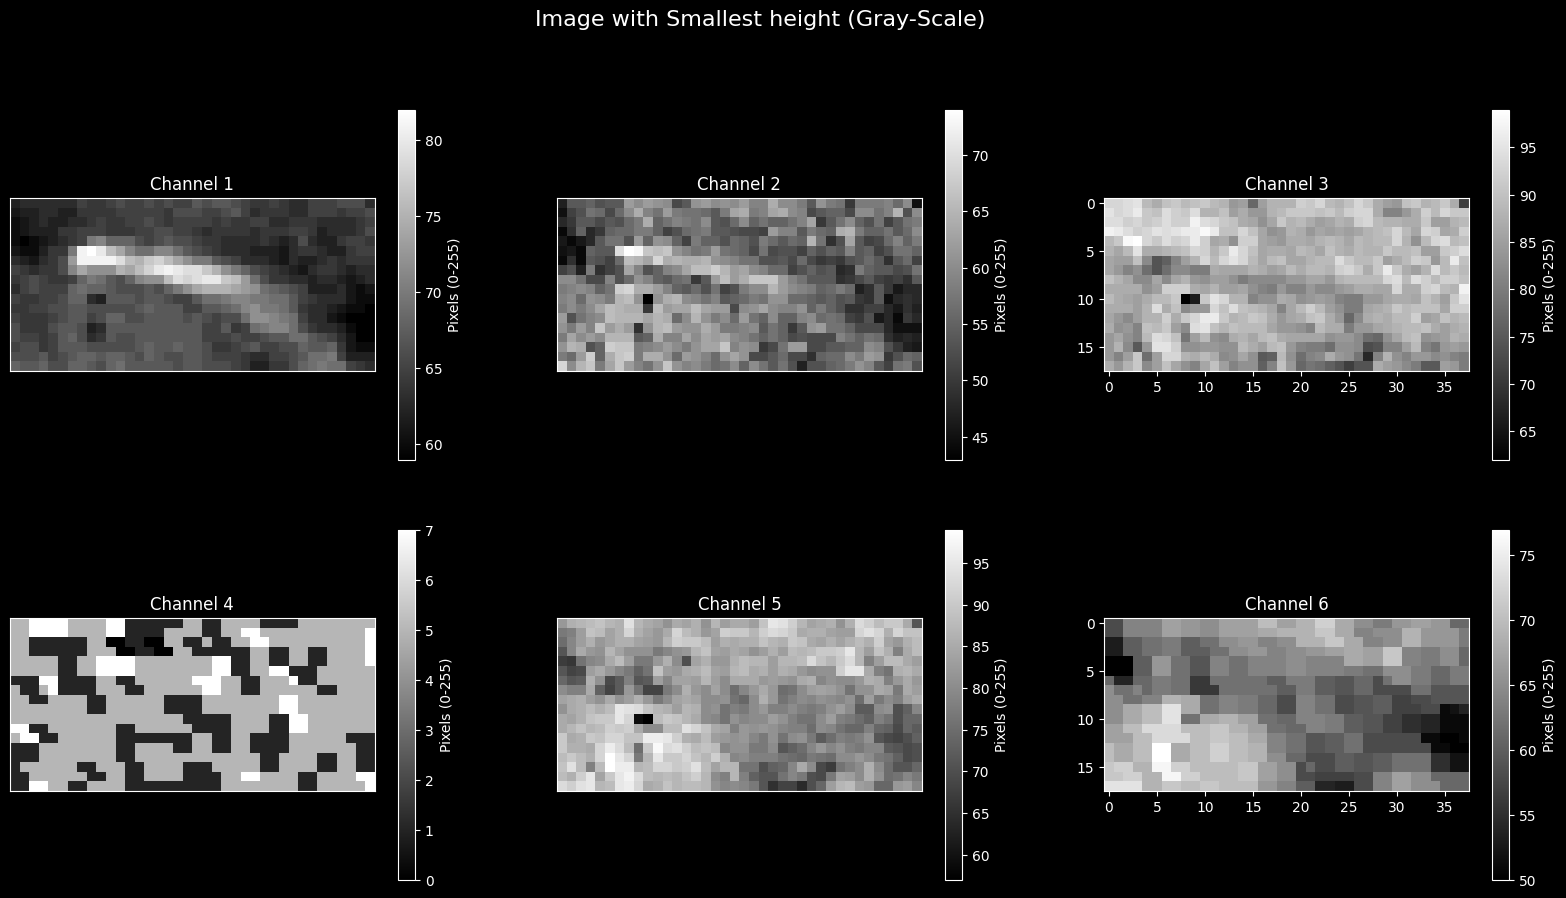

In [ ]:
srtsh = X[rastframe[rastframe['TiffHeight']==rastframe['TiffHeight'].min()].index[0]]
srbsh = Y[rastframe[rastframe['TiffHeight']==rastframe['TiffHeight'].min()].index[0]][0]
figtif, axtif = plt.subplots(2,3, figsize=(20,10))
for i in range(2):
  for j in range(2):
    axtif[i][j].axes.xaxis.set_visible(False)
    axtif[i][j].axes.yaxis.set_visible(False)
plt.suptitle("Image with Smallest height (Gray-Scale)",fontsize=16)
for i in range(1,7):
  plt.subplot(2,3,i)
  plt.imshow(srtsh[i-1],cmap=Gray)
  plt.title(f'Channel {i}')
  plt.colorbar(label="Pixels (0-255)")
plt.show()

Shape: (18, 38)


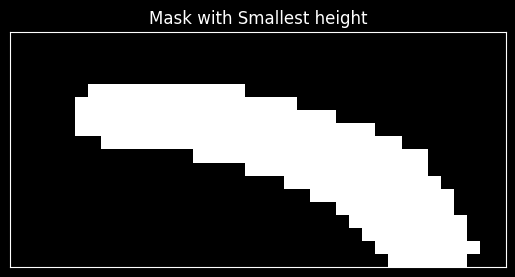

In [ ]:
print("Shape:",srbsh.shape)
plt.imshow(srbsh,cmap=Gray)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.title("Mask with Smallest height")
plt.show()

####Smallest Width image

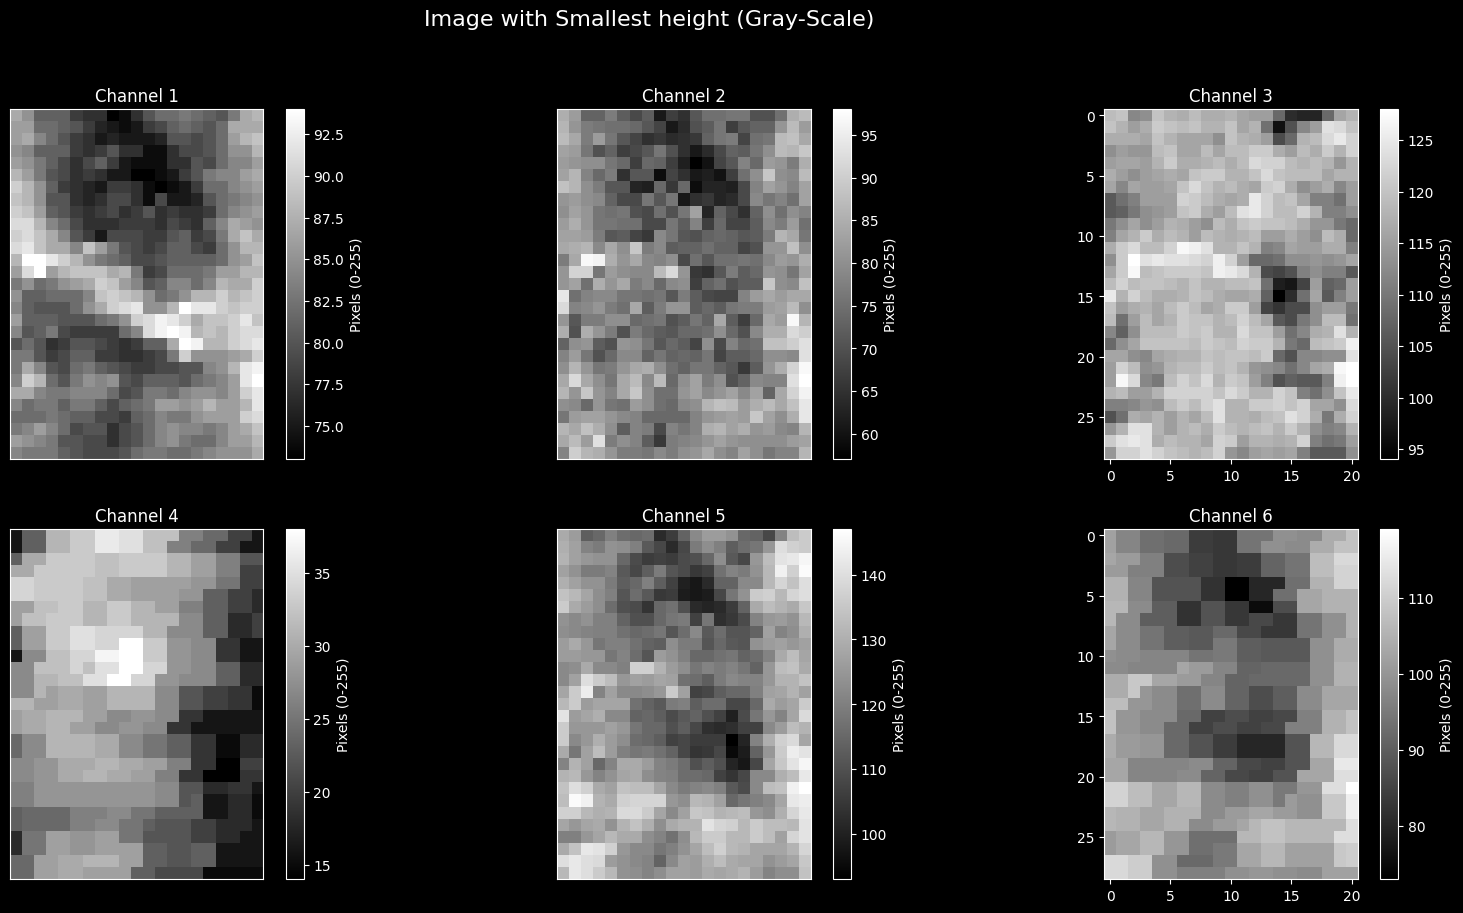

In [ ]:
srtsw = X[rastframe[rastframe['TiffWidth']==rastframe['TiffWidth'].min()].index[0]]
srbsw = Y[rastframe[rastframe['TiffWidth']==rastframe['TiffWidth'].min()].index[0]][0]
figtif, axtif = plt.subplots(2,3, figsize=(20,10))
for i in range(2):
  for j in range(2):
    axtif[i][j].axes.xaxis.set_visible(False)
    axtif[i][j].axes.yaxis.set_visible(False)
plt.suptitle("Image with Smallest height (Gray-Scale)",fontsize=16)
for i in range(1,7):
  plt.subplot(2,3,i)
  plt.imshow(srtsw[i-1],cmap=Gray)
  plt.title(f'Channel {i}')
  plt.colorbar(label="Pixels (0-255)")
plt.show()

Shape: (29, 21)


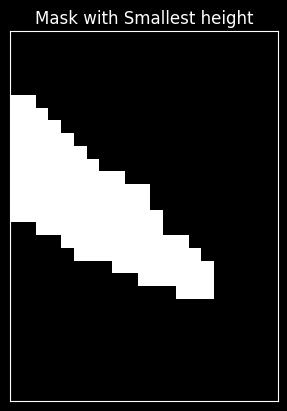

In [ ]:
print("Shape:",srbsw.shape)
plt.imshow(srbsw,cmap=Gray)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.title("Mask with Smallest height")
plt.show()

#### Image Dimensions dataframe

Now that we have seen the extremes of the dataset, we can try to understand the distribution of image dimensions and pinpoint the best input dimension for feeding into a model.

In [ ]:
tifframe = rastframe.loc[:,['TiffHeight','TiffWidth']]

In [ ]:
bmpframe = rastframe.loc[:,['BmpHeight','BmpWidth']]

In [ ]:
tifframe[tifframe.duplicated(subset=['TiffHeight','TiffWidth'])]

TiffHeight  TiffWidth
99           83         82
110          46         52
133          27         31
135          83         86
148          83         82
198          83         77
204          92         76
213          73         60
219          55         76
222         129        127
223          46         55
258         129        133
269          83         90
282         129        127

In [ ]:
tifframe[tifframe.duplicated(subset=['TiffHeight','TiffWidth'])].count()

TiffHeight    14
TiffWidth     14
dtype: int64

This means there are some images with a common pattern of pixel dimensions,however, this is too few a quantity of images to set a standard for pixel dimension.

In [ ]:
rastframe.describe()

TiffHeight    TiffWidth    BmpHeight     BmpWidth
count   352.000000   352.000000   352.000000   352.000000
mean    215.409091   234.980114   215.409091   234.980114
std     209.459181   434.431111   209.459181   434.431111
min      18.000000    21.000000    18.000000    21.000000
25%      92.000000    84.000000    92.000000    84.000000
50%     147.000000   132.500000   147.000000   132.500000
75%     255.750000   251.500000   255.750000   251.500000
max    1572.000000  7080.000000  1572.000000  7080.000000

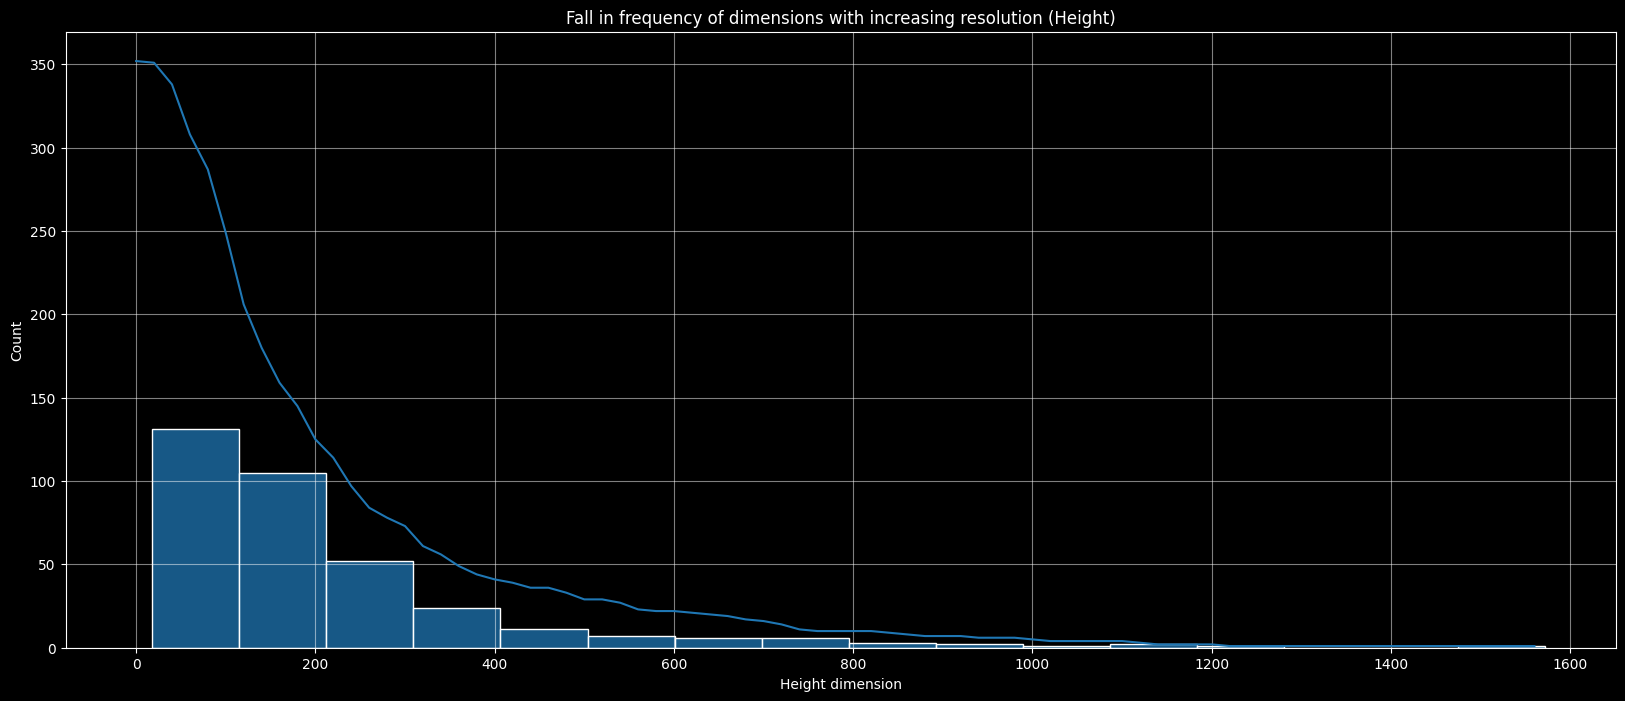

In [ ]:
plt.figure(figsize=(20,8))
plt.plot([i for i in range(0,tifframe['TiffHeight'].max(),20)] ,[len(tifframe[tifframe['TiffHeight']>i]) for i in range(0,tifframe['TiffHeight'].max(),20)],c="tab:blue")
sns.histplot(data=tifframe, x="TiffHeight",bins=16, stat="count", color="tab:blue",thresh=0.5)
plt.xlabel("Height dimension")
plt.grid(alpha=0.5)
plt.title("Fall in frequency of dimensions with increasing resolution (Height)")
plt.show()

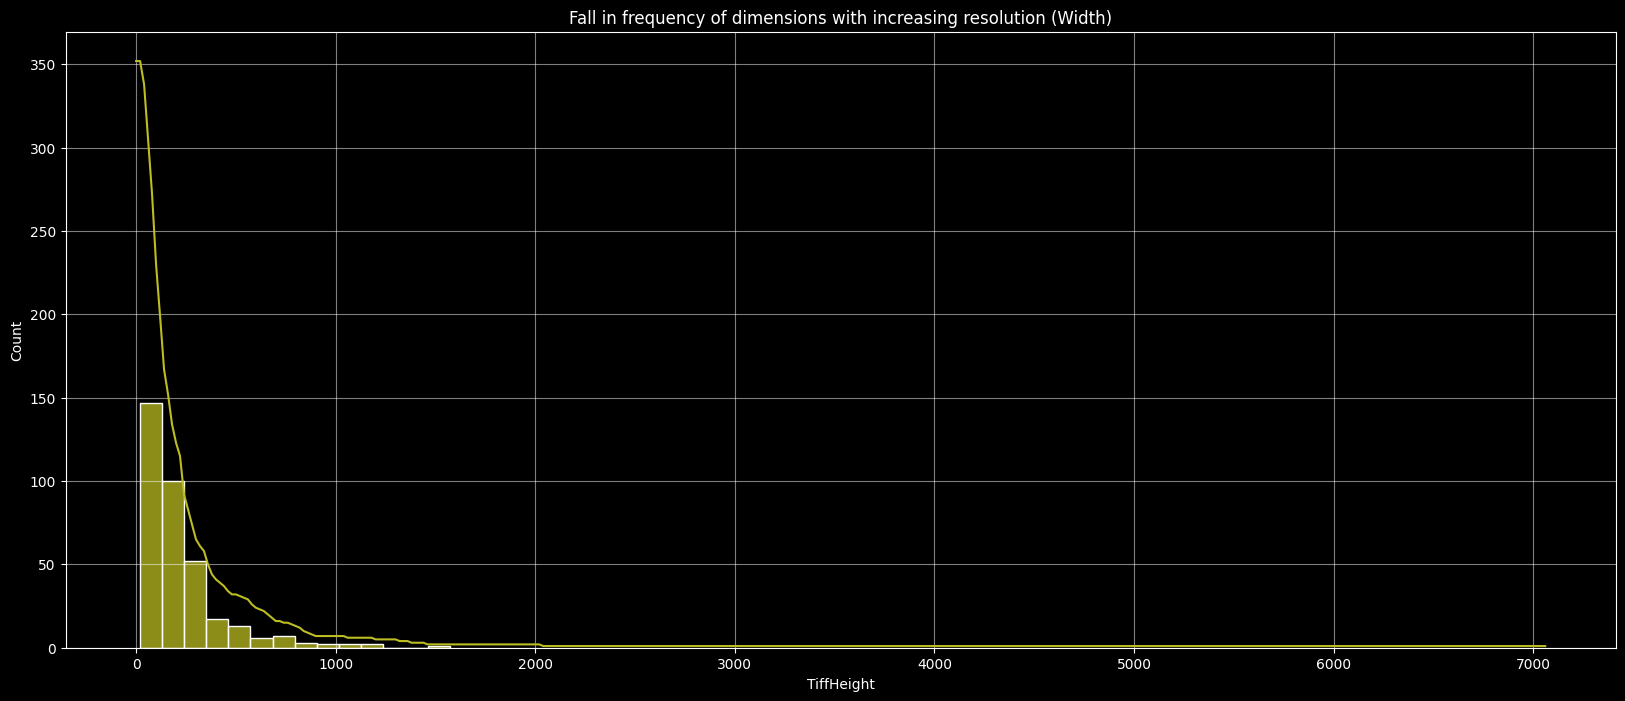

In [ ]:
plt.figure(figsize=(20,8))
plt.plot([i for i in range(0,tifframe['TiffWidth'].max(),20)] ,[len(tifframe[tifframe['TiffWidth']>i]) for i in range(0,tifframe['TiffWidth'].max(),20)],c="tab:olive")
sns.histplot(data=tifframe, x="TiffHeight",bins=14,color="tab:olive",stat="count",pthresh=0.5)
plt.grid(alpha=0.5)
plt.title("Fall in frequency of dimensions with increasing resolution (Width)")
plt.show()

<Figure size 800x1200 with 0 Axes>

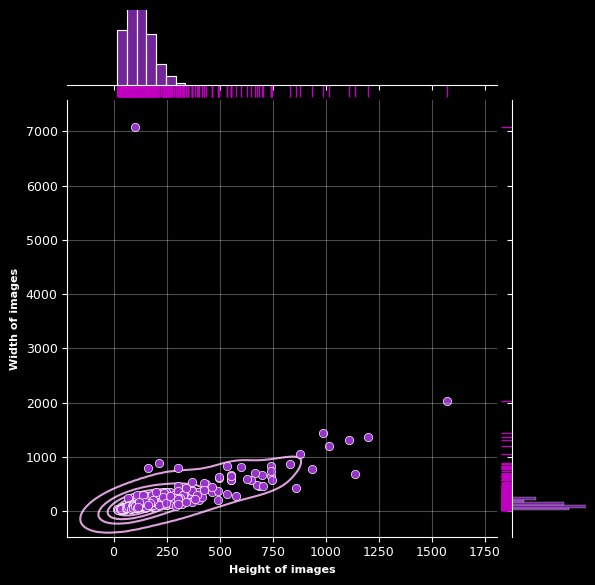

In [ ]:
plt.figure(figsize=(8,12))
g = sns.jointplot(data=tifframe, x="TiffHeight", y="TiffWidth",color="darkorchid")
g.plot_joint(sns.kdeplot, color="plum", zorder=0, levels=6)
g.plot_marginals(sns.rugplot, color="m", height=-.15, clip_on=False)
plt.xlabel('Height of images',fontsize=8,fontweight='bold'),plt.ylabel('Width of images',fontsize=8,fontweight='bold')
plt.tick_params(labelsize=9)
plt.grid(alpha=0.3)
plt.show()

In [ ]:
print(f"Height values greater than 100: {len(bmpframe[bmpframe['BmpHeight']>100].index)}\nWidth values greater than 100: {len(bmpframe[bmpframe['BmpWidth']>100].index)}")

Height values greater than 100: 249
Width values greater than 100: 230


In [ ]:
print(f"Height values greater than 200: {len(bmpframe[bmpframe['BmpHeight']>200].index)}\nWidth values greater than 200: {len(bmpframe[bmpframe['BmpWidth']>200].index)}")

Height values greater than 200: 125
Width values greater than 200: 123


In [ ]:
print(f"Height values greater than 250: {len(bmpframe[bmpframe['BmpHeight']>250].index)}\nWidth values greater than 250: {len(bmpframe[bmpframe['BmpWidth']>250].index)}")

Height values greater than 250: 91
Width values greater than 250: 89


In [ ]:
print(f"Height values greater than 300: {len(bmpframe[bmpframe['BmpWidth']>300].index)}\nWidth values greater than 300: {len(bmpframe[bmpframe['BmpHeight']>300].index)}")

Height values greater than 300: 65
Width values greater than 300: 73


In [ ]:
print(f"Height values greater than 500: {len(bmpframe[bmpframe['BmpWidth']>500].index)}\nWidth values greater than 500: {len(bmpframe[bmpframe['BmpHeight']>500].index)}")

Height values greater than 500: 32
Width values greater than 500: 29


In [ ]:
print(f"Height values greater than 1000: {len(bmpframe[bmpframe['BmpWidth']>1000].index)}\nWidth values greater than 1000: {len(bmpframe[bmpframe['BmpHeight']>1000].index)}")

Height values greater than 1000: 7
Width values greater than 1000: 5


In [ ]:
print(f"Height values greater than 2000: {len(bmpframe[bmpframe['BmpWidth']>2000].index)}\nWidth values greater than 2000: {len(bmpframe[bmpframe['BmpHeight']>2000].index)}")

Height values greater than 2000: 2
Width values greater than 2000: 0


In [ ]:
print(f"Height values greater than 5000: {len(bmpframe[bmpframe['BmpWidth']>5000].index)}\nWidth values greater than 5000: {len(bmpframe[bmpframe['BmpHeight']>5000].index)}")

Height values greater than 5000: 1
Width values greater than 5000: 0


The reason this is checked is because we must understand and analyse which dimensions is the best to set as the standard resolution for the model's input layer. This is a tricky job as we must pick the best combination in order to maximize the utility of the dataset while reducing the amount of upsampling/downsampling or the forsaking of redundant pixels for mosaiking.

#### Raster band Histogram 📊

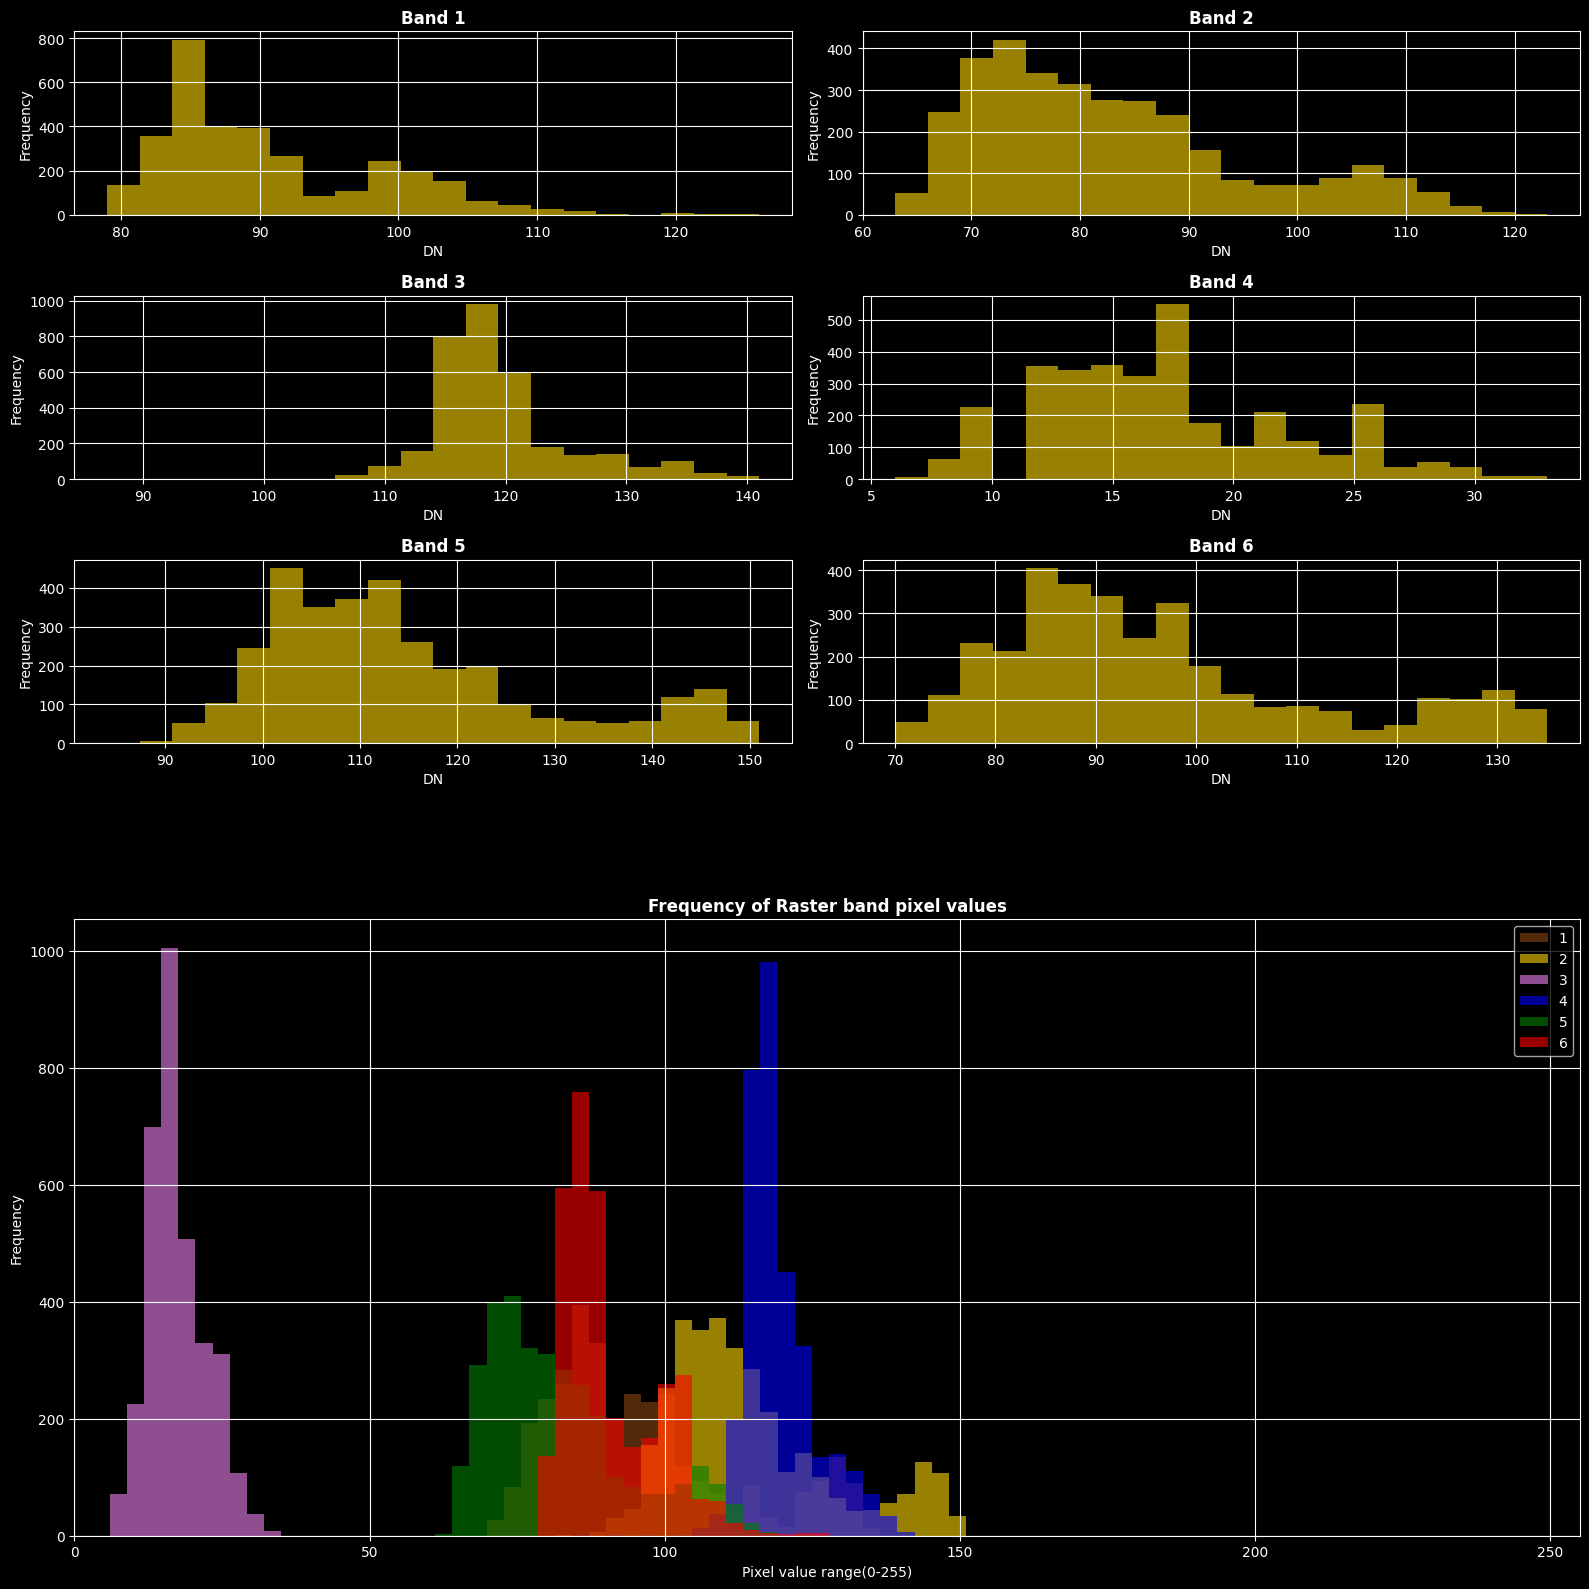

In [ ]:
fighist = plt.figure(figsize=(16,16),layout="tight")
ax1 = fighist.add_subplot(6, 2, 1)
ax2 = fighist.add_subplot(6, 2, 2)
ax3 = fighist.add_subplot(6, 2, 3)
ax4 = fighist.add_subplot(6, 2, 4)
ax5 = fighist.add_subplot(6, 2, 5)
ax6 = fighist.add_subplot(6, 2, 6)
axbig = fighist.add_subplot(212)
show_hist(tifa[0], bins=20, lw=0.0, stacked=False, alpha=0.6, title="Band 1",ax=ax1);ax1.get_legend().remove()
show_hist(tifa[1], bins=20, lw=0.0, stacked=False, alpha=0.6, title="Band 2",ax=ax2);ax2.get_legend().remove()
show_hist(tifa[2], bins=20, lw=0.0, stacked=False, alpha=0.6, title="Band 3",ax=ax3);ax3.get_legend().remove()
show_hist(tifa[3], bins=20, lw=0.0, stacked=False, alpha=0.6, title="Band 4",ax=ax4);ax4.get_legend().remove()
show_hist(tifa[4], bins=20, lw=0.0, stacked=False, alpha=0.6, title="Band 5",ax=ax5);ax5.get_legend().remove()
show_hist(tifa[5], bins=20, lw=0.0, stacked=False, alpha=0.6, title="Band 6",ax=ax6);ax6.get_legend().remove()
show_hist(tifa, bins=50, lw=0.0, stacked=False, alpha=0.6,histtype="stepfilled", title="Frequency of Raster band pixel values",ax=axbig)
axbig.set_xlim(xmin=0, xmax = 255)
axbig.set_xlabel("Pixel value range(0-255)")
axbig.legend(['1','2','3','4','5','6'])
plt.show()

The histograms shown above represents the frequency of pixel value distributions of all the images. We can infer the following:

*   The third band's distribution is completely secluded from the other bands<br><br>
*    As seen in previous image visualizations, the first and second bands almost always depicts the smoke, making it the primary bands to resemble the presence of a smoke plume in an image. <br><br>
*   The fourth and sixth bands concentrate thier distributions onto a very small range of values, while the first, second and fifth bands have a wider distribution of pixel values.



###Result

From the analysis, we can infer the following:


*   The first two bands contain the ranges of wavelength that can help extract the smoke plumes we are trying to identify.
*   A majority of images in the dataset are small and they lie in the range of 100 to 300 pixel size.

*   There are some images that are large, thereby creating a large range of image sizes, creating an issue of loss with respect of resizing.



## **Feature Engineering** 📐


We will now perform some feature engineering by applying some common feature engineering approaches to transforming the data into a usable form for training models. We will use resizing and augmentation, some common approaches to engineer features into a usable form and see thier efficacy.

###Removal of redundant images

As seen from the image exploratory analysis, we have found that one of the largest images has no viable mask for seperating smoke. We must therefore remove it and the ones similiar to it from the data we are using for the model.

In [ ]:
def maxi(array):
  if array.max() == 0:
    return False
  else:
    return True

In [ ]:
len(X),len(Y)

(352, 352)

In [ ]:
emptymasks = []
for i in range(len(Y)):
  if not maxi(Y[i]):
    emptymasks.append(i)

In [ ]:
emptymasks

[293]

In [ ]:
for j in emptymasks:
  del Y[j]
  del X[j]

In [ ]:
len(X),len(Y)

(351, 351)

Therefore, it seems like only the one image was redundant in this sense.

###Resizing

For this notebook, we will use bicubic interpolation to resize the images to a common size and see the difference in images. Bicubic interpolation is a simple and effective approach to resizing an image, but it has its own drawbacks, which we will see. We will first apply it on the smallest images and then the largest image, and then check the impact of interpolating multiband images on a segmentation model.

In [ ]:
X[0].shape, Y[0].shape

((6, 397, 352), (1, 397, 352))

In [ ]:
for i in range(len(Y)):
  Y[i] = Y[i][0]

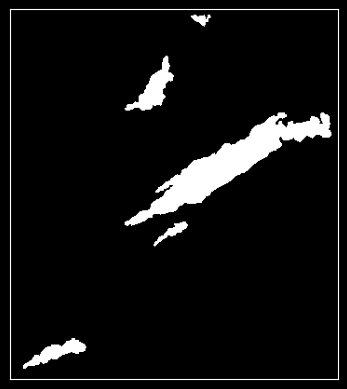

In [ ]:
plt.imshow(Y[0],cmap=Gray)
ax=plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

In [ ]:
srtsh.shape

(6, 18, 38)

In [ ]:
new_height = 256
new_width = 256

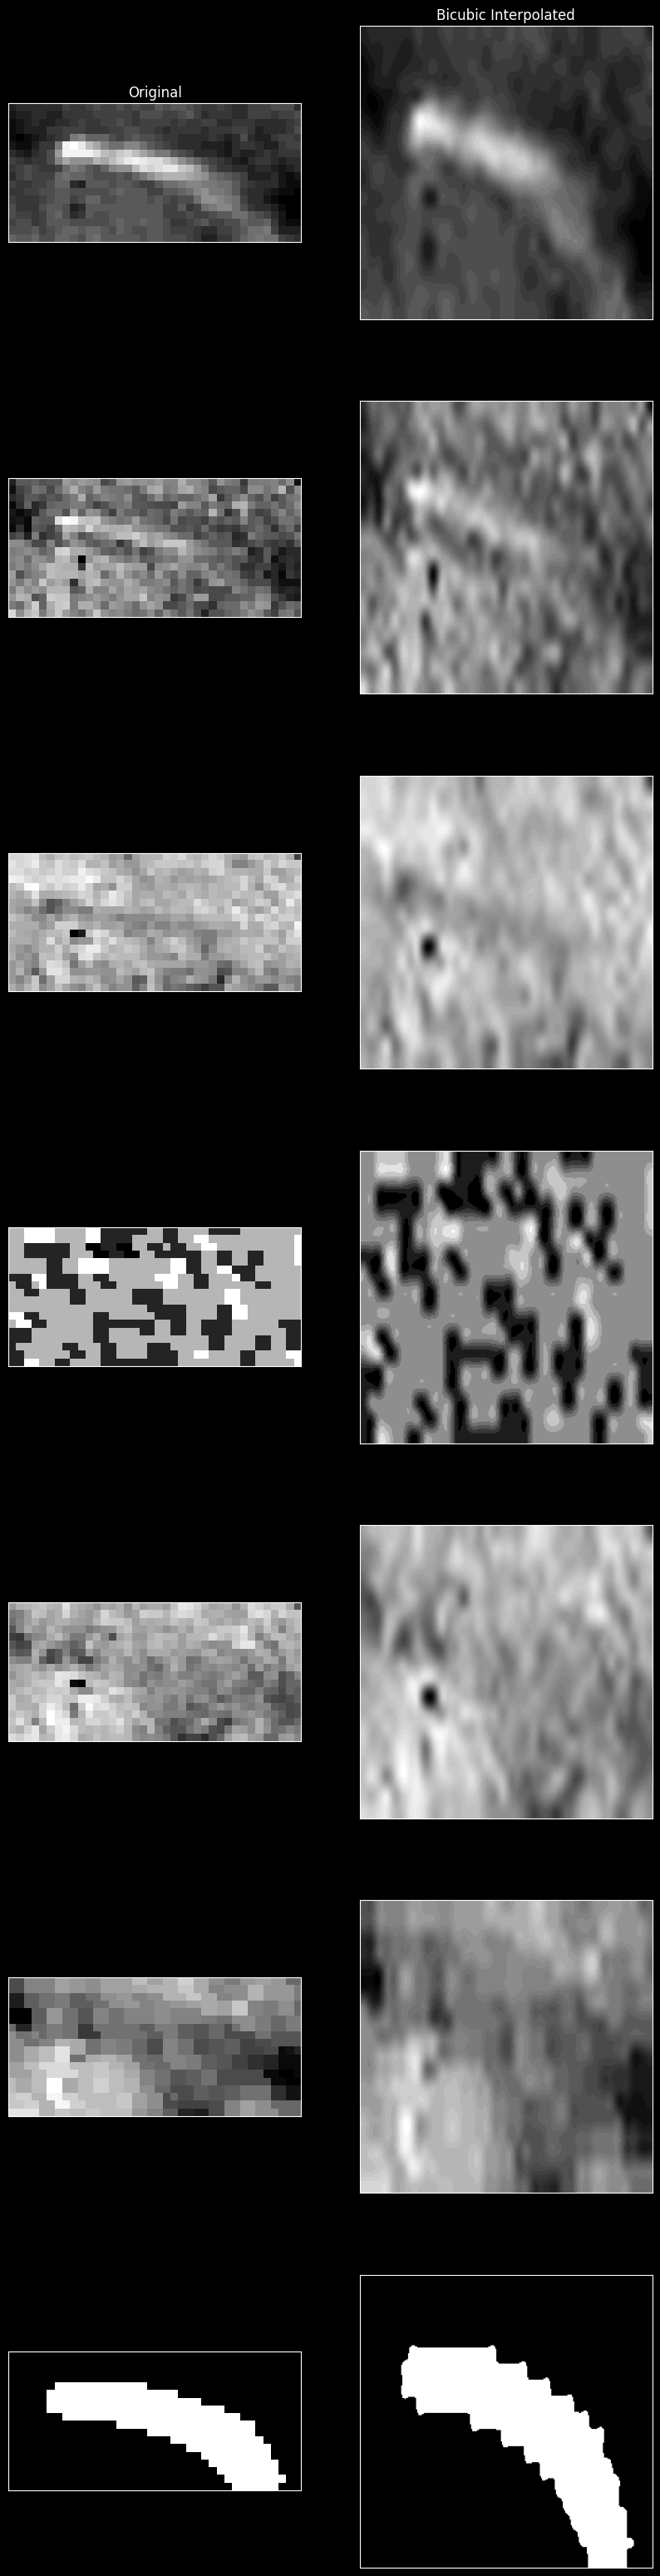

In [ ]:
interfig,interax = plt.subplots(7,2,figsize=(10,40))
interax[0][0].set_title("Original")
interax[0][1].set_title("Bicubic Interpolated")
for i in range(6):
  interax[i][0].axes.xaxis.set_visible(False)
  interax[i][0].axes.yaxis.set_visible(False)
  interax[i][1].axes.xaxis.set_visible(False)
  interax[i][1].axes.yaxis.set_visible(False)
  interax[i][0].imshow(srtsh[i],cmap=Gray)
  interax[i][1].imshow(cv2.resize(srtsh[i],dsize=(new_height, new_width), interpolation=cv2.INTER_CUBIC),cmap=Gray)
interax[6][0].axes.xaxis.set_visible(False)
interax[6][0].axes.yaxis.set_visible(False)
interax[6][1].axes.xaxis.set_visible(False)
interax[6][1].axes.yaxis.set_visible(False)
interax[6][0].imshow(srbsh,cmap=Gray)
interax[6][1].imshow(cv2.threshold(cv2.resize(srbsh,dsize=(new_height, new_width), interpolation=cv2.INTER_CUBIC).astype(np.uint8),250,255, cv2.THRESH_BINARY)[1],cmap=Gray)
plt.show()

Upon applying bicubic interpolation on the smallest image in the dataset, we get the above result. While the mask seems to be intact for the most part, the images become heavily distorted due to the small size of the original image.

Now let us try with the largest image.

In [ ]:
srtlh.shape

(6, 1572, 2039)

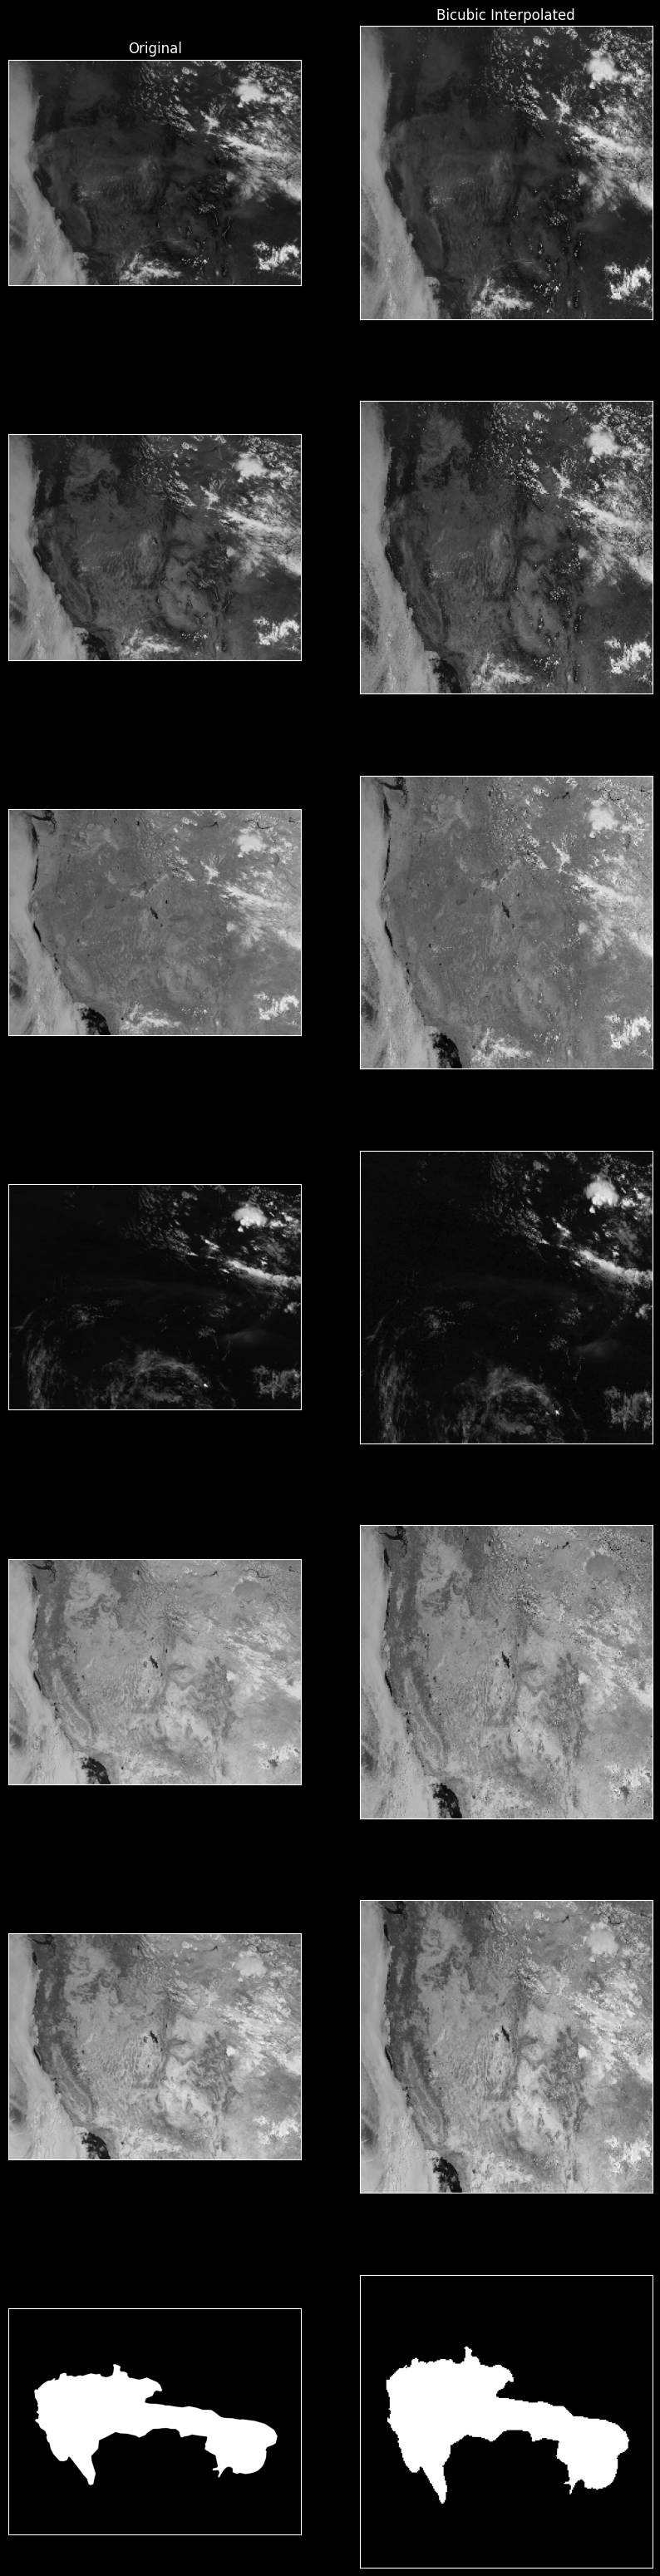

In [ ]:
interfig,interax = plt.subplots(7,2,figsize=(10,40))
interax[0][0].set_title("Original")
interax[0][1].set_title("Bicubic Interpolated")
for i in range(6):
  interax[i][0].axes.xaxis.set_visible(False)
  interax[i][0].axes.yaxis.set_visible(False)
  interax[i][1].axes.xaxis.set_visible(False)
  interax[i][1].axes.yaxis.set_visible(False)
  interax[i][0].imshow(srtlh[i],cmap=Gray)
  interax[i][1].imshow(cv2.resize(srtlh[i],dsize=(new_height, new_width), interpolation=cv2.INTER_CUBIC),cmap=Gray)
interax[6][0].axes.xaxis.set_visible(False)
interax[6][0].axes.yaxis.set_visible(False)
interax[6][1].axes.xaxis.set_visible(False)
interax[6][1].axes.yaxis.set_visible(False)
interax[6][0].imshow(srblh,cmap=Gray)
interax[6][1].imshow(cv2.threshold(cv2.resize(srblh,dsize=(new_height, new_width), interpolation=cv2.INTER_CUBIC).astype(np.uint8),250,255, cv2.THRESH_BINARY)[1],cmap=Gray)
plt.show()

While bicubic interpolation can resize effectively with a manageable information loss, this method may not viable for the dataset since a lot of the images are small. While it still manages to resize with some loss, it is best to use other methods like mosaicking.

The following shows the program to resize all the images

In [ ]:
interX = []
for i in range(len(X)):
  interX.append([cv2.resize(j,dsize=(new_height, new_width), interpolation=cv2.INTER_CUBIC).astype(np.uint8) for j in X[i]])

In [ ]:
interX[2]

[array([[85, 85, 85, ..., 81, 81, 81],
        [85, 85, 85, ..., 81, 81, 81],
        [85, 85, 85, ..., 81, 81, 81],
        ...,
        [81, 81, 81, ..., 81, 81, 81],
        [81, 81, 81, ..., 81, 81, 81],
        [81, 81, 81, ..., 81, 81, 81]], dtype=uint8),
 array([[87, 86, 86, ..., 76, 76, 76],
        [87, 86, 86, ..., 76, 76, 76],
        [86, 86, 86, ..., 76, 76, 76],
        ...,
        [79, 79, 79, ..., 77, 77, 76],
        [80, 80, 80, ..., 77, 77, 77],
        [80, 80, 80, ..., 77, 77, 77]], dtype=uint8),
 array([[106, 106, 105, ...,  99, 100, 100],
        [106, 106, 105, ...,  99, 100, 100],
        [105, 105, 105, ...,  99,  99,  99],
        ...,
        [100, 100, 100, ..., 103, 103, 103],
        [100, 100, 100, ..., 103, 103, 103],
        [100, 100, 100, ..., 103, 103, 103]], dtype=uint8),
 array([[9, 9, 9, ..., 7, 7, 7],
        [9, 9, 9, ..., 7, 7, 7],
        [9, 9, 9, ..., 7, 7, 7],
        ...,
        [5, 5, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5],


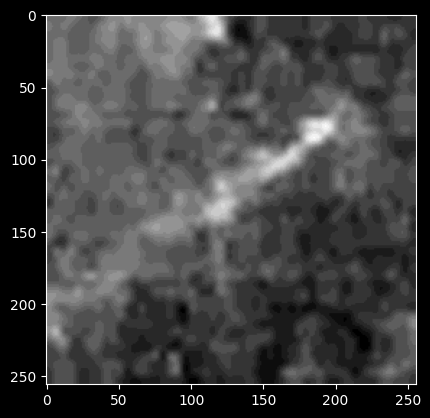

In [ ]:
plt.imshow(interX[2][0],cmap=Gray)
plt.show()

In [ ]:
interY = [cv2.threshold(cv2.resize(i,dsize=(new_height, new_width), interpolation=cv2.INTER_CUBIC).astype(np.uint8),250,255, cv2.THRESH_BINARY)[1] for i in Y]

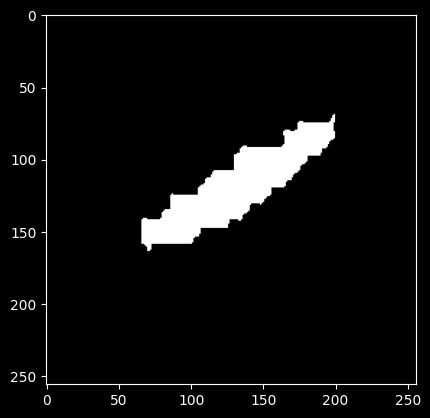

In [ ]:
plt.imshow(interY[2],cmap=Gray)
plt.show()

As mentioned before, bicubic interpolation is found to be a very lossy approach to resizing small images and it can be seen again in this sample. However we can see that the masks are almost unaffected by resizing due to the fact that they are bitmaps.

###Augmentation of new images

We will use the ```cv2``` library to rotate the images and generate new images for increasing our dataset size since the number of images are a bit small. We will showcase the ```cv2.getRotationMatrix2D``` function with a sample image.

[[96 95 96 ... 79 74 75]
 [96 95 96 ... 79 74 75]
 [94 94 95 ... 88 81 71]
 ...
 [60 59 59 ... 70 70 69]
 [60 60 60 ... 68 69 70]
 [60 60 60 ... 68 69 70]]
(601, 821)


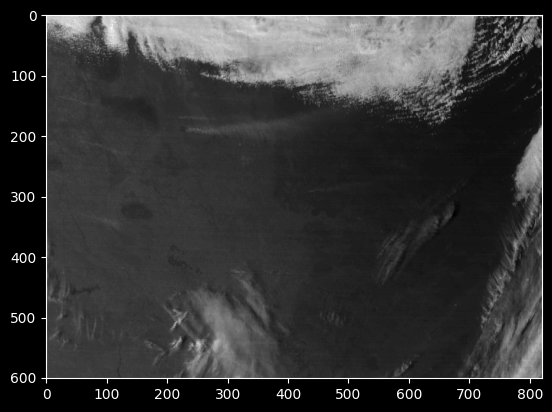

In [ ]:
print(X[100][0])
print(X[100][0].shape)
plt.imshow(X[100][0],cmap=Gray)
plt.show()

In [ ]:
def augmentrot(array):
  image_array = np.array(array)
  rotation_matrix = cv2.getRotationMatrix2D((image_array.shape[1] // 2, image_array.shape[0] // 2), 180, 1.0)
  rotated_image = cv2.warpAffine(image_array, rotation_matrix, (image_array.shape[1],image_array.shape[0]))
  return rotated_image

[[70 69 68 ... 60 60 60]
 [70 69 68 ... 60 60 60]
 [69 70 70 ... 59 59 60]
 ...
 [71 81 88 ... 95 94 94]
 [75 74 79 ... 96 95 96]
 [75 74 79 ... 96 95 96]]
(601, 821)


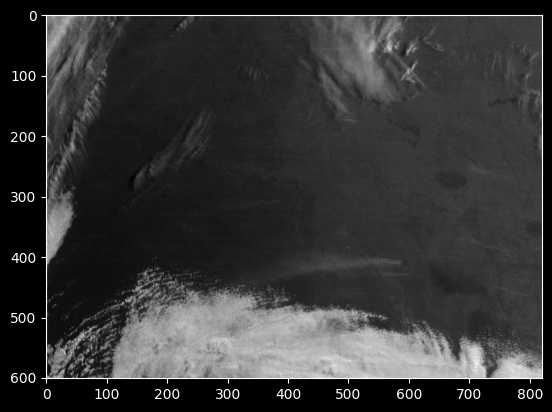

In [ ]:
print(augmentrot(X[100][0]))
print(augmentrot(X[100][0]).shape)
plt.imshow(augmentrot(X[100][0]),cmap=Gray)
plt.show()

Now we will implement the same function from above and augment our whole data.

In [ ]:
for i in range(len(X)):
  interX.append([augmentrot(j) for j in interX[i]])

In [ ]:
len(interX)

702

In [ ]:
for i in range(len(Y)):
  interY.append(augmentrot(interY[i]))

In [ ]:
len(interY)

702

## **Model Pipeline** 📈

Now that we have engineered our dataset, we will test our process with a standardly used architecture and model. We will be using the `U-Net` architecture along with the `ResNet34` backbone, which is a commonly used architecture for segmentation use-cases. We will also validate the model created and see if it can be a viable solution to our problem.

#### Convert to Tensors

We will first convert the images into tensors for inputting into the model

In [ ]:
intX = np.array([tf.reshape(tf.convert_to_tensor(array),(256,256,6)) for array in interX])
intY = np.array([tf.convert_to_tensor(array,dtype=np.uint8) for array in interY])

In [ ]:
intX.shape

(702, 256, 256, 6)

In [ ]:
intY.shape

(702, 256, 256)

####Dataset Split

Next, we will split the dataset for training and testing purposes using ```train_test_split```

In [ ]:
intxtrain,intxtest,intytrain,intytest=train_test_split(intX,intY,test_size=0.2,random_state=5)

In [ ]:
len(intxtrain),len(intytrain)

(561, 561)

In [ ]:
len(intxtest),len(intytest)

(141, 141)

In [ ]:
intxtrain[0].shape

(256, 256, 6)

####U-Net Model

Now it is time to define and compile the architecture. We will use the ```segmentation_models``` library for this task. We will perform the Backbone preprocessing and train the data with

In [ ]:
BACKBONE = "resnet34"
preprocess = sm.get_preprocessing(BACKBONE)

In [ ]:
model = sm.Unet(backbone_name=BACKBONE,encoder_weights=None,input_shape=(256,256,6))
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 6  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 6)  18          ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 6)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 128, 128, 64  18816       ['zero_padding2d[0][0]']   

In [ ]:
intxtrain = preprocess(intxtrain)
intxtest = preprocess(intxtest)

In [ ]:
intytrain = (intytrain/255).astype(np.float32)

In [ ]:
intytrain.dtype

dtype('float32')

In [ ]:
intytest = (intytest/255).astype(np.float32)

In [ ]:
intytest.dtype

dtype('float32')

The following shows taking half of the test data and keeping it for the validation set.

In [ ]:
intxval = intxtest[:(len(intxtest)//2)]
intxtest = intxtest[(len(intxtest)//2):len(intxtest)]

In [ ]:
intyval = intytest[:(len(intytest)//2)]
intytest = intytest[(len(intytest)//2):len(intytest)]

In [ ]:
history = model.fit(x=intxtrain,y=intytrain,batch_size=1,verbose=1,epochs=200,validation_data=(intxval,intyval))

After fitting, we will now save this model's weights.

In [ ]:
model.save('bicubic_image_model200.hdf5')

####Results

Now that we have saved the model, we can evaluate it.

In [ ]:
model = keras.models.load_model("/content/bicubic_image_model200.hdf5")

In [ ]:
_,acc = model.evaluate(intxtest,intytest)

3/3 [==============================] - 3s 764ms/step - loss: 7.0506 - iou_score: 0.1399


In [ ]:
print("Accuracy using Bicubic interpolated images =",acc*100,"%")

Accuracy using Bicubic interpolated images = 13.989870250225067 %


This shows that our process of preprocessing is ineffective as the accuracy is very less.

In [ ]:
loss=model.history['loss']
val_loss=model.history['val_loss']

In [ ]:
epochs=range(1,len(loss)+1)

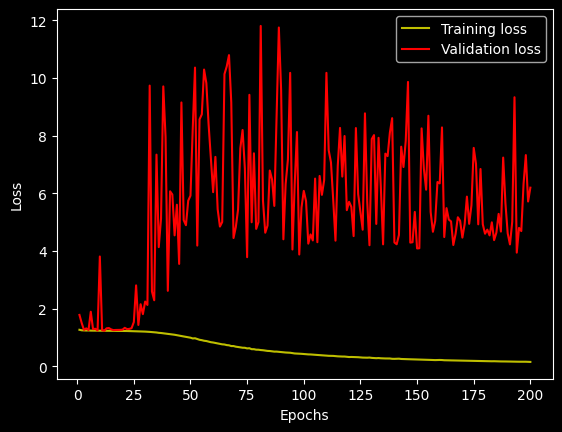

In [ ]:
plt.plot(epochs,loss,'y',label="Training loss")
plt.plot(epochs,val_loss,'r',label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

As we can see above, the validation loss is very volatile and high.

In [ ]:
iou = history.history['iou_score']
val_iou = history.history['val_iou_score']

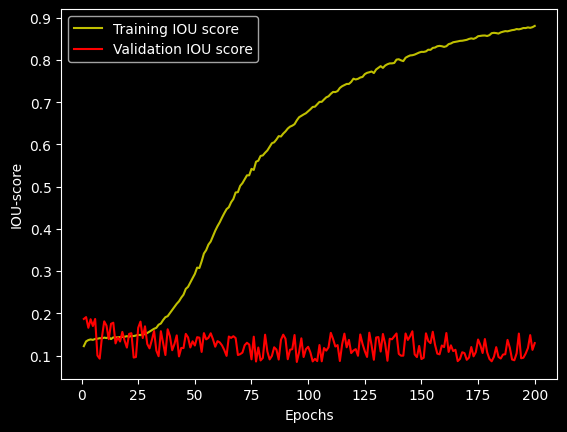

In [ ]:
plt.plot(epochs,iou,'y',label="Training IOU score")
plt.plot(epochs,val_iou,'r',label="Validation IOU score")
plt.xlabel("Epochs")
plt.ylabel("IOU-score")
plt.legend()
plt.show()

As we can see, the validation IOU score is very bad and the model is overfitted. We can conclude that the feature engineering techniques would be ineffective for the model training. 

##**Conclusion**

*   The first and second bands contain the smoke while the other four bands do not.
*   The dataset has a wide range of image sizes
*   Resizing using bicubic interpolation + augmentation was found to be ineffective and we need a better way to resize and create new images, as it is leading to overfitting.
*   Common image processing techniques would not be viable for the given dataset to be changed into a usable form.

